


# PART 2 - Modelling & Progress report

## A. EDA Summary

In the previous part, Exploratory Data Analysis, we cleaned the data, engineered new features and conducted visual analysis of the dataset.

In the Correlation & statistical analysis section of the previous notebook we have created a correlation matrix and plotted a heatmap. Although correlation matrix and heatmap did not give us a lot of meaningful information due to the nature of the datasat which contains only categorical variables, from the visual and statistical analysis of the features we could confidently say that our data has some underlying associations that have potential of becoming uselful in predicting severity of accidents. Among others, we detected the following patterns:

* time: frequency and severity of accidents vary in different moths and weekdays
* type of area: rural areas seem to have significantly higher ratio of serious and fatal accidents than urban areas
* speed limit appears to be quite influential factor when it comes to the accident severity
* there seems to be an association between the accident frequency and demographic features such as age or gender of the drivers

In this part, we will train and test a number of models and evaluate their performance by comparing results with the baseline model.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import *
pd.options.display.max_columns = 999
import patsy
from __future__ import division
import itertools

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve

## B. Initial Modelling

### 1. Reading in the table

In [2]:
main = pd.read_csv('/Users/Mags/Desktop/Capstone_datasets/UK_accidents_data/RoadSafetyData_2015/main_acc_veh_merged.csv', low_memory= False) 
main.head(2)

,Accident_Index,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Skidding_and_Overturning,Vehicle_Leaving_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Sex_of_Driver,Age_Band_of_Driver,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Hour,Month,Ped_Crossing
0,201501BS70001,goods,0,Turning right,0,0,0,Front,1,Male,56 - 65,Metropolitan Police,Slight,1,1,Mon,C,Single cgwy,30.0,T or staggered junction,Give way/uncontr,Unclassified,Dk-lit,Fine/no wind,Dry,0.0,0.0,Urban,19.0,Jan,0.0
1,201501BS70002,car,0,Turning right,0,0,0,Front,1,Male,46 - 55,Metropolitan Police,Slight,1,1,Mon,Unclassified,Single cgwy,30.0,T or staggered junction,Give way/uncontr,A,Daylight,Fine/no wind,Dry,0.0,0.0,Urban,8.0,Jan,0.0


### 2. Preparing target and predictor matrices

#### 2.1. Target

The target for the model is Accident Severity, however, as indicated earlier, we are dealing with severe class imbalance in this category:

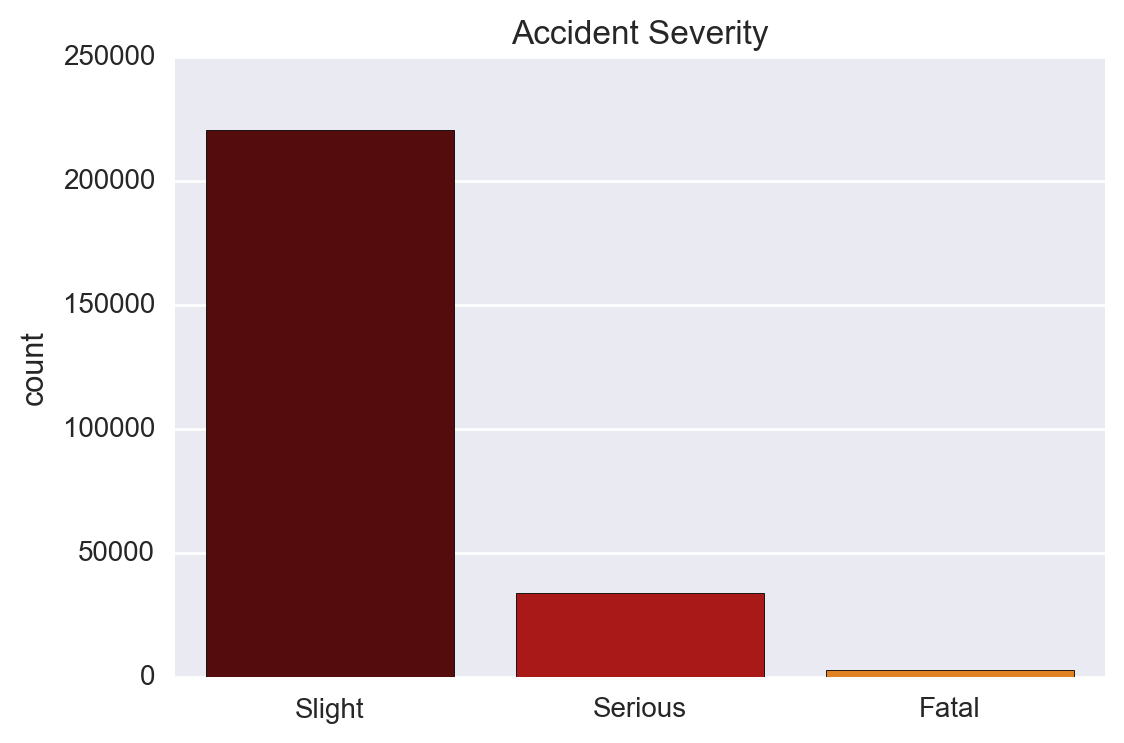

In [3]:
plt.figure(figsize = (6, 4))
sns.countplot(x="Accident_Severity", data=main, palette='gist_heat')
plt.xlabel("")
plt.title("Accident Severity")
plt.show()

To deal with the class imbalance problem we are going to undertake the following steps:
1. Merge two minority classes, ie. 'Serious' and 'Fatal' into one, creating a binary target with two classes: 'Slight' vs 'non Slight' which we are going to call 'Severe'.
2. Undersample the majority category, 'Slight', so that the classes have similar number of observations.

In [4]:
#Replacing small classes name with "Severe":
main.loc[:,'Accident_Severity'] = main.Accident_Severity.map(lambda x: "Severe" if x == "Serious" 
                                                            or x== 'Fatal' else x) 

main.Accident_Severity.value_counts()

Slight    220713
Severe     37095
Name: Accident_Severity, dtype: int64

In [5]:
#Creating new, 'balanced' df:
bal_main = main[main["Accident_Severity"] == 'Severe']

#Sampling from 'Slight' class and adding to new df:
bal_main = bal_main.append(main[main["Accident_Severity"] == "Slight"].sample(n=37095, 
                                                                              replace=False, random_state=42))
bal_main =  bal_main.sort_values(by="Accident_Index", ascending=True)
bal_main.reset_index(inplace=True, drop=True)
bal_main.shape

(74190, 31)

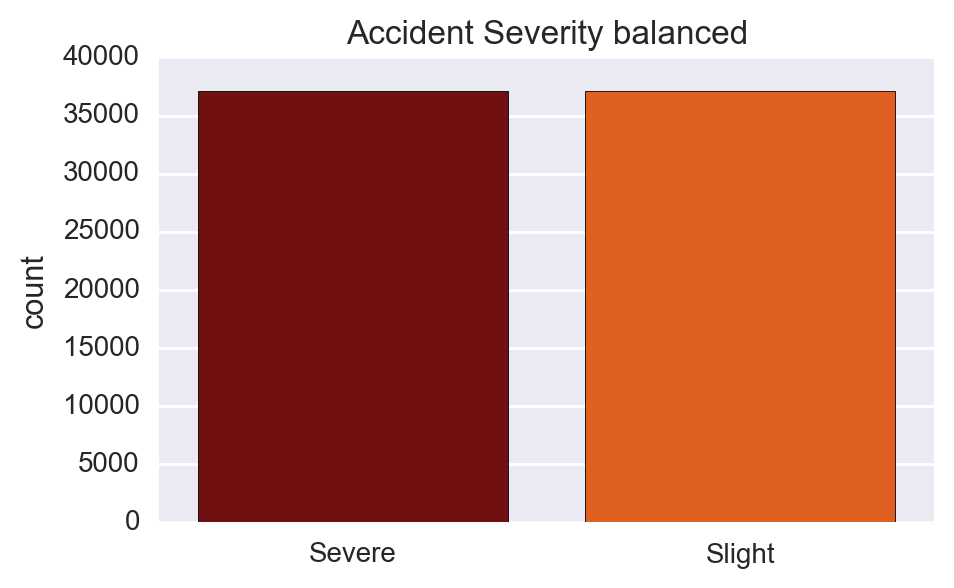

In [6]:
#Plotting new Accident Severity distribution
plt.figure(figsize = (5, 3))
sns.countplot(x="Accident_Severity", data=bal_main, palette='gist_heat')
plt.xlabel("")
plt.title("Accident Severity balanced")
plt.show()

Now both classes in the target column have the same number of observations.

In [7]:
#Changing the labels of accident severity to 0 and 1:
severity = {'Severe':1, 'Slight':0}
bal_main["Accident_Severity"].replace(severity, inplace=True)

In [8]:
#Creating target:
y = bal_main.Accident_Severity.values
y.shape

(74190,)

#### 2.2. Predictor matrix
To construct a predictor matrix we will need to create dummy variables for all categorical features we want to use as predictors. For that, we will use Patsy package for creating design matrices.

As Patsy refuses to handle column names containing numbers and non-alphabet symbols, we need to rename some of the columns:

In [9]:
#Renaming columns
bal_main.rename(columns={'Vehicle_Location-Restricted_Lane': 'Vehicle_Loc', '1st_Point_of_Impact':'First_POI', '1st_Road_Class': 'First_Road_Class', "2nd_Road_Class": "Scnd_Rd_Class", 'Was_Vehicle_Left_Hand_Drive?': 'Left_Hand_Drive'}, inplace=True)

#Preparing features formula and dummy variables
features = "~ C(Vehicle_Type) + C(Towing_and_Articulation) + C(Vehicle_Manoeuvre)+ C(Vehicle_Loc) + C(Skidding_and_Overturning) + C(Vehicle_Leaving_Carriageway) + C(First_POI) + C(Left_Hand_Drive) + C(Sex_of_Driver) + C(Age_Band_of_Driver) + C(Police_Force) + C(Number_of_Vehicles) + C(Number_of_Casualties) +C(Day_of_Week) + C(First_Road_Class) + C(Road_Type) + C(Speed_limit) + C(Junction_Detail) + C(Junction_Control) + C(Scnd_Rd_Class) + C(Light_Conditions) + C(Weather_Conditions) + C(Road_Surface_Conditions) + C(Special_Conditions_at_Site) + C(Carriageway_Hazards) + C(Urban_or_Rural_Area) + C(Hour) + C(Month) + C(Ped_Crossing) -1"

#Creating design matrix
X = patsy.dmatrix(features, data=bal_main, return_type='dataframe')
X.shape

(74190, 186)

### 3. Baseline model accuracy
To assess the performance of the models we will need to compare their accuracy to the baseline model accuracy. As our target is binary and we have the same number of observations in both classes, then our baseline model accuracy will be simply 0.5:

In [10]:
baseline = len(bal_main[bal_main.Accident_Severity == 1])/len(bal_main)
print "Baseline accuracy:", baseline

Baseline accuracy: 0.5


### 4. Splitting data into test and train sets
This step is to help reduce bias of the model.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state =42)

### 5. Logistic regression
#### 5.1. Logistic regression without regularization

For the first model, to get the feel of the data, let's run a default logistic regression, without regularization applied. To achieve this in Scikit-learn, we need to set the penalty parameter to L2 and use a large number as a value for C parameter.

In [12]:
log_reg = LogisticRegression(penalty='l2', C=10**10)
log_reg.fit(X_train, y_train)

LogisticRegression(C=10000000000, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Values of 10 largest coefficients are as follows:

In [13]:
coeffs = pd.DataFrame({'Coefficient':log_reg.coef_[0],'Feature':X.columns})
coeffs["ABS_Coefficient"] = abs(coeffs.Coefficient)
coeffs.sort_values(by='ABS_Coefficient', ascending=False, inplace=True)
coeffs.reset_index(inplace=True, drop=True)
coeffs[:20]

,Coefficient,Feature,ABS_Coefficient
0,1.116052,C(Number_of_Casualties)[T.>3],1.116052
1,1.029394,C(Police_Force)[T.Grampian],1.029394
2,0.881004,C(Age_Band_of_Driver)[T.Over 75],0.881004
3,-0.791452,C(Police_Force)[T.Metropolitan Police],0.791452
4,-0.750253,C(Number_of_Vehicles)[T.2],0.750253
5,0.659885,C(Age_Band_of_Driver)[T.66 - 75],0.659885
6,0.653414,C(Vehicle_Type)[motorcycle],0.653414
7,0.647706,C(Age_Band_of_Driver)[T.56 - 65],0.647706
8,-0.638016,C(Number_of_Vehicles)[T.3],0.638016
9,0.611047,C(Police_Force)[T.Gloucestershire],0.611047


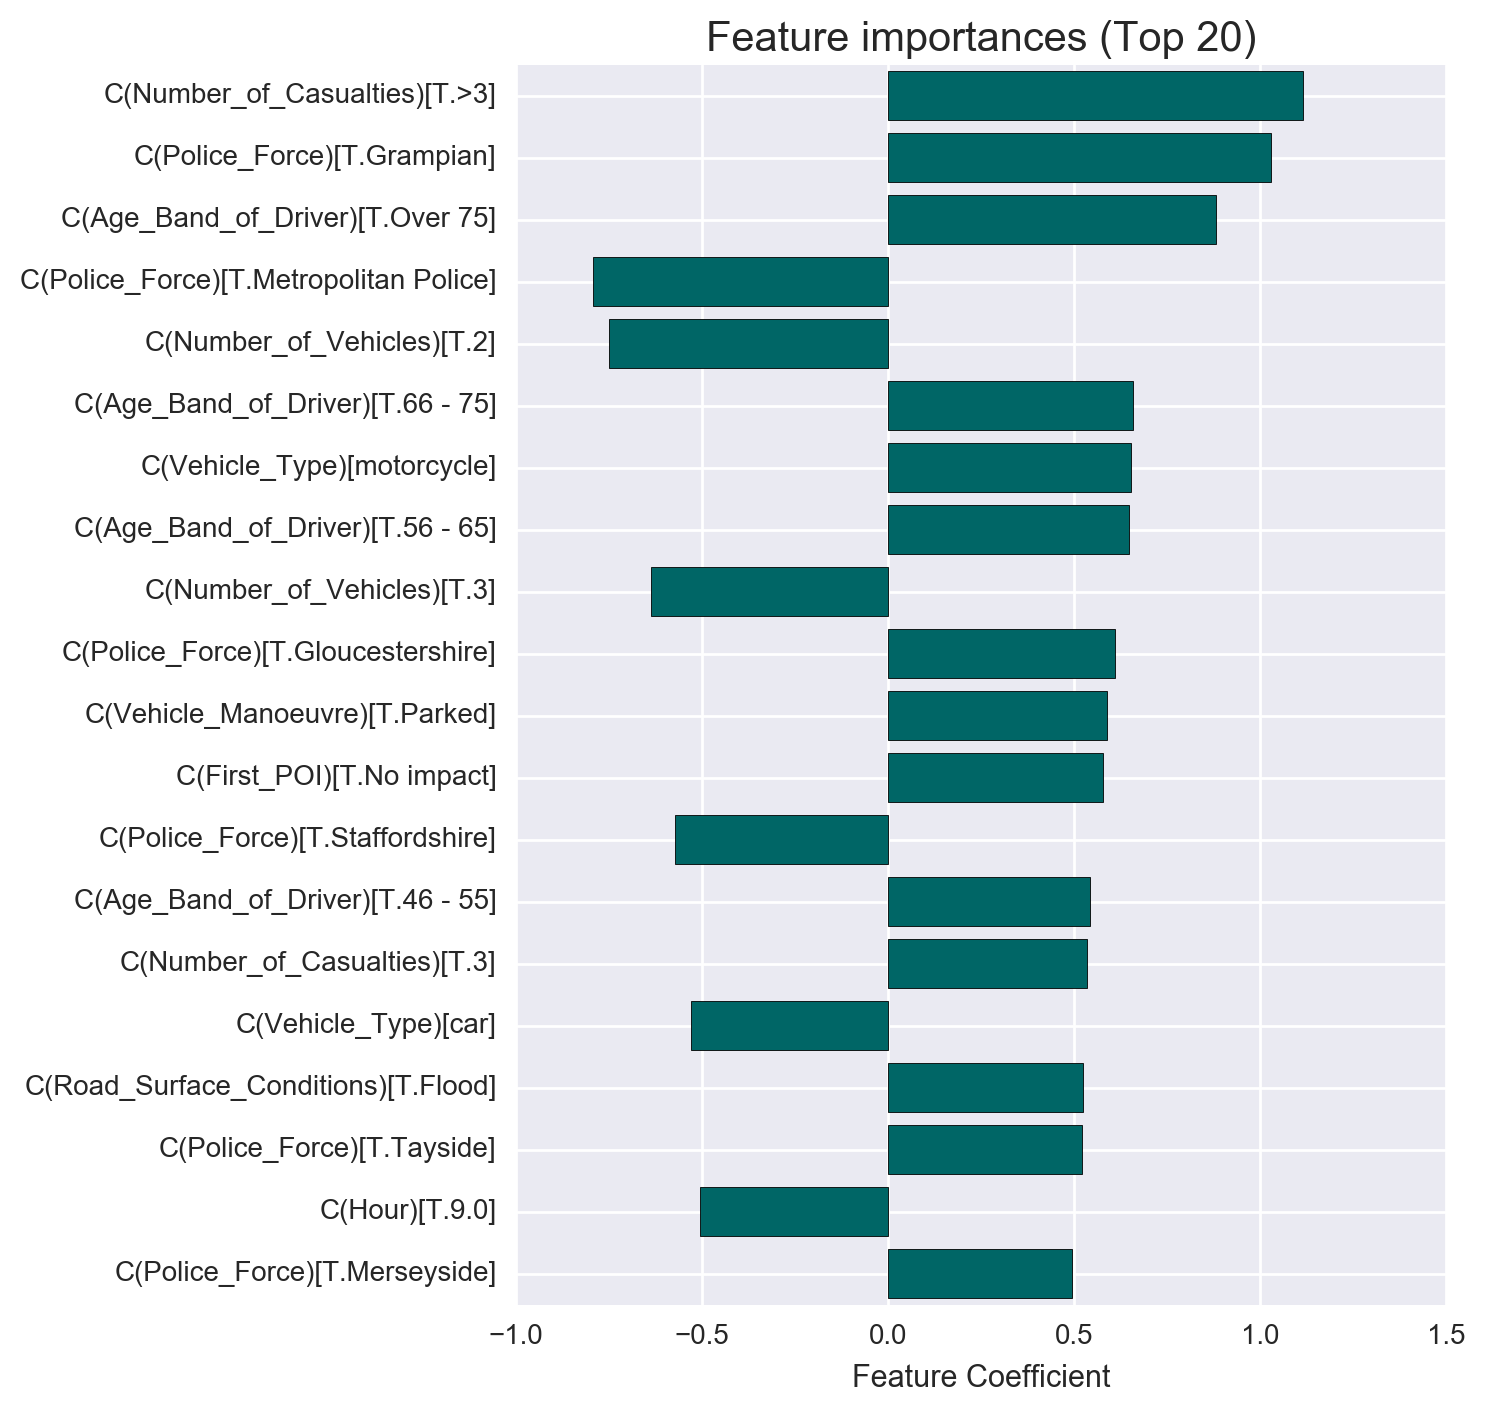

In [46]:
#Plotting feature importances:

plt.figure(figsize = (6, 8))
plt.title("Feature importances (Top 20)", fontsize = 15)
plt.barh(coeffs.index[:20].sort_values(ascending=False), coeffs.Coefficient[:20], align="center", color = '#006666')
plt.xlabel('Feature Coefficient')
plt.yticks(range(X.shape[1]), coeffs.Feature[:20].sort_index(ascending=False))
plt.ylim([-0.5, 19.5])
plt.show()


From the above it can be seen that the features that have the highest positive association with accidents being severe, are Number of Casulaties larger than 3, Grampian Police Force and Age Band over 75. The features strongest associated with slight accidents are Police Force: Metropolitan and Number of Vehicles: 2.

In [15]:
#Accuracy score for test set
y_hat = log_reg.predict(X_test)
score = accuracy_score(y_test, y_hat)
print 'Accuracy score:', score

Accuracy score: 0.662353416903


In [16]:
#Cross-validated score
y_hat_CV = cross_val_predict(log_reg, X_test, y_test, cv=5)
CV_score = np.mean(cross_val_score(log_reg, X_test, y_test, cv=5))
print 'Cross-validated accuracy score:', CV_score

Cross-validated accuracy score: 0.661949190981


Both above accuracy scores are of very similar values of 0.66 which is higher than a baseline model. In order to check other evaluation metrics, we will print a classification report and plot confusion matrix and ROC curve.

In [17]:
print "Classification report:"
print classification_report(y_test, y_hat_CV)

Classification report:
             precision    recall  f1-score   support

          0       0.66      0.66      0.66     11122
          1       0.66      0.66      0.66     11135

avg / total       0.66      0.66      0.66     22257



In the above classification report we can see that both precision and recall have the same values. This means that the model is equally good in predicting the number of true severe accidents from all predicted severe accidents (true positives and false positives) as in predicting number of true severe accidents from all severe accidents (true positives and false negatives).
We can also see that both precision and recall have same values for both classes meaning that our model performs equally well at predicting severe and slight accidents.

In [18]:
def plot_confusion_matrix(cm, classes, title, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()/ 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

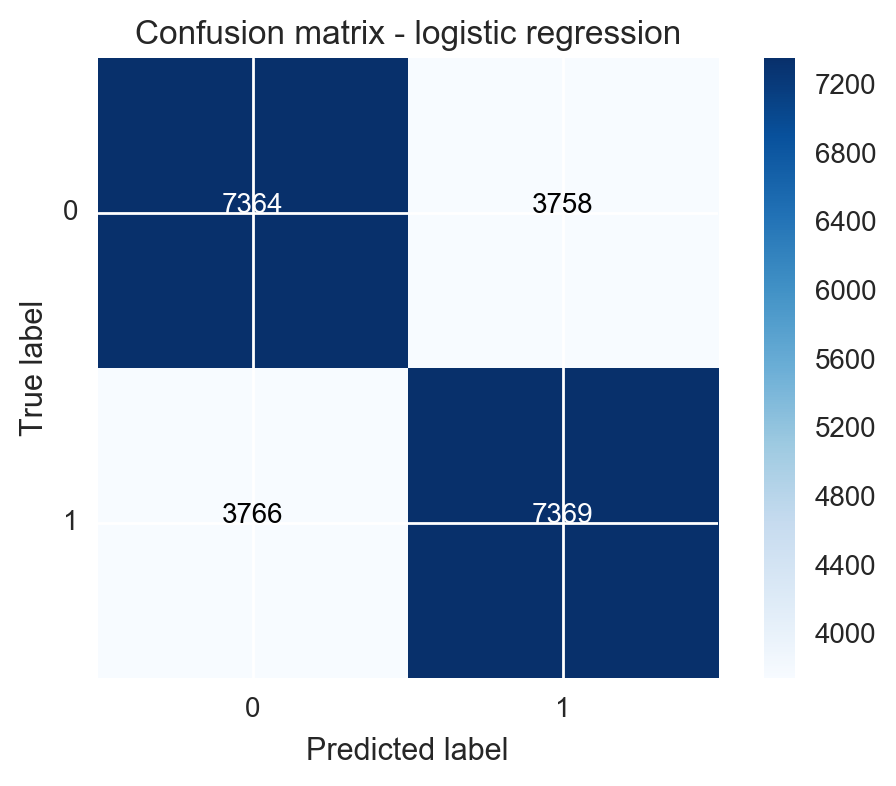

In [19]:
conf_matrix = (confusion_matrix(y_test, y_hat_CV))
plot_confusion_matrix(conf_matrix, [0,1], "Confusion matrix - logistic regression", cmap=plt.cm.Blues)

The confusion matrix confirms the findings from classification report, that the model is equally good at predicting severe and slight accidents.

In [20]:
def plot_ROC(model, title):

    #Plotting ROC curve
    y_score = model.decision_function(X_test)

    # Find the area under the curve
    FPR, TPR, THR = roc_curve(y_test, y_score)
    ROC_AUC = auc(FPR, TPR)

    # Plot ROC curve for class 1
    plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1-specificity)', fontsize=12)
    plt.ylabel('True Positive Rate (sensitivity)', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc="lower right")
    plt.show()
    return

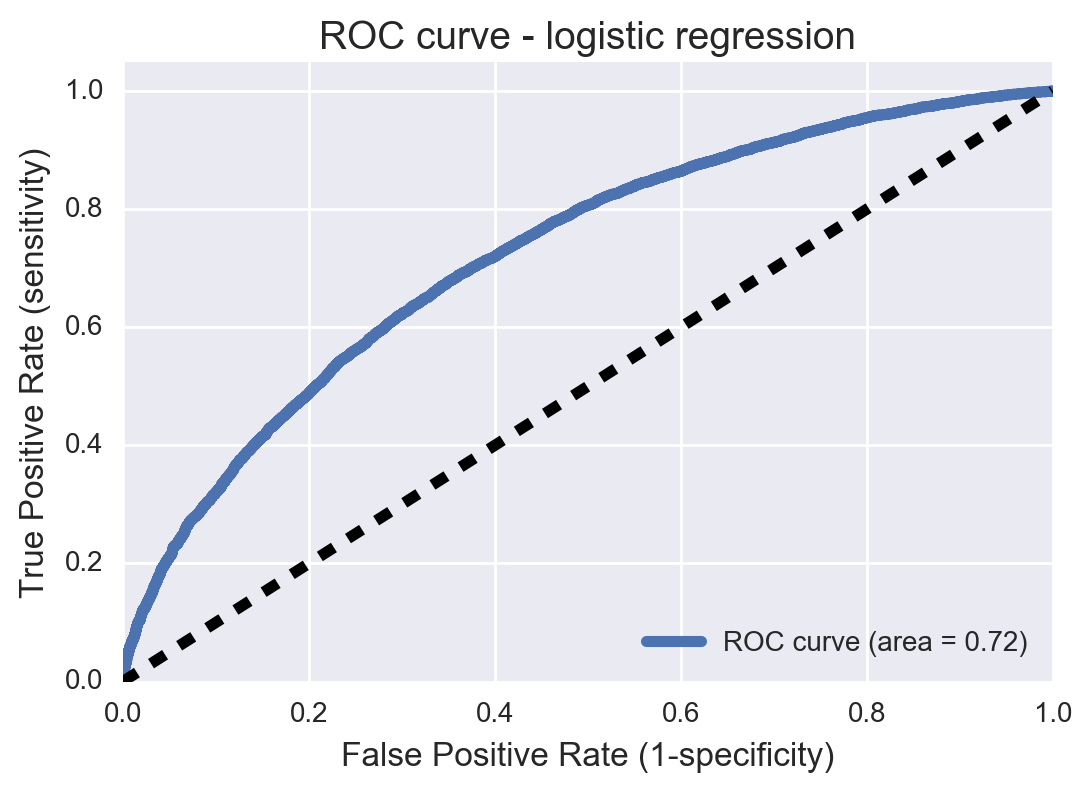

In [21]:
plot_ROC(log_reg, "ROC curve - logistic regression")

The ROC curve helps to visualise how well the model performs in comaprison to the baseline. It also tells us that the probability that our model will properly classify severe accident is 0.72.

Let's look at the learning curve for the model:

In [22]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 20)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring= 'accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(color='w')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

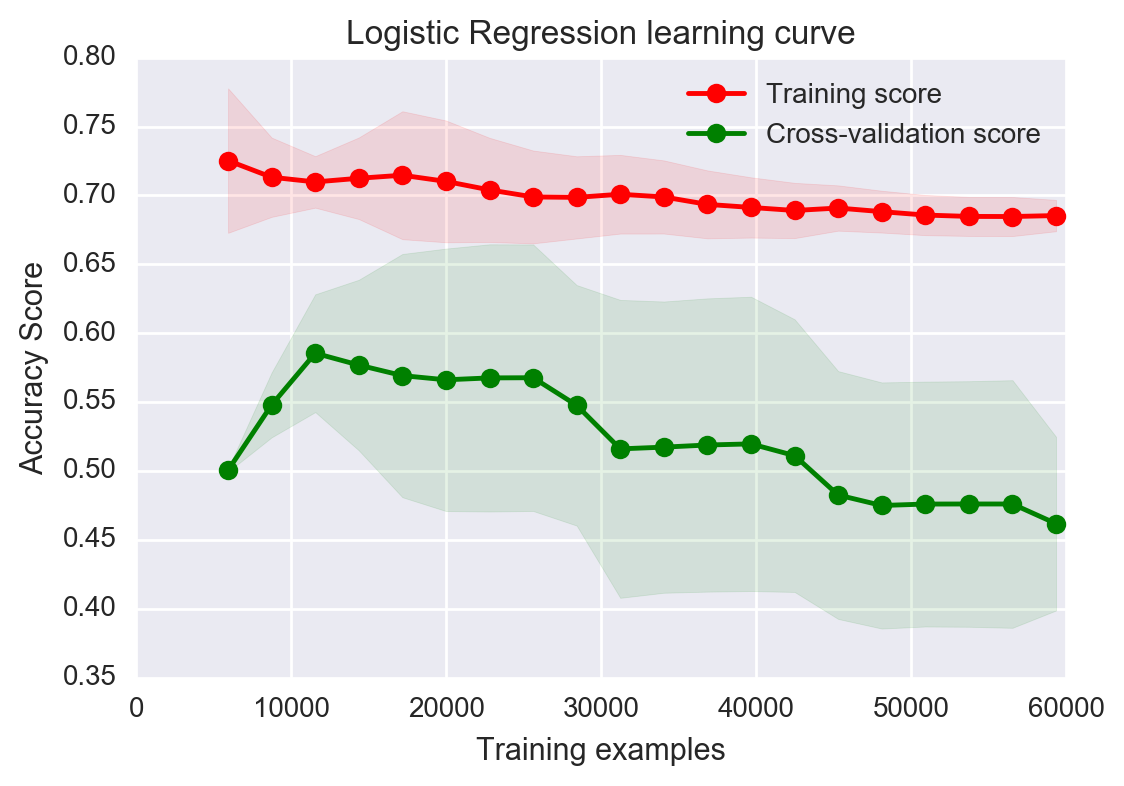

In [23]:
plot_learning_curve(log_reg, title = "Logistic Regression learning curve", X=X, y=y, cv=5)
plt.show()

From the above chart we can see that the cross-validation score actually decreases with increasing volume of training samples, hitting couple of plateaus along the way. Such a large gap between the training and cross-validation score could mean that we have a substantial bias in the data.


#### 5.2. Logistic regression with regularization using Gridsearch
With the help of Gridsearch, we now look for the parameters that give us the best scores for the logistic regression model. We are going to use 5 fold cross-validation to optimize the model.

In [24]:
logreg_parameters = {'penalty':['l1','l2'],'C':np.logspace(-5,1,25), 'solver': ['liblinear']}

gridsearch = GridSearchCV(LogisticRegression(), cv=5, param_grid=logreg_parameters, scoring="accuracy")
gridsearch.fit(X_train,y_train) 

print 'Best parameters:', gridsearch.best_params_
print 'Best score:', gridsearch.best_score_

Best parameters: {'penalty': 'l1', 'C': 1.7782794100389228, 'solver': 'liblinear'}
Best score: 0.656788554484


The Gridsearch returned the best parameters for the logistic regression model: L1 penalty and value of C of approxomately 1.78.

In [25]:
y_hat_gr = gridsearch.predict(X_test)
score = accuracy_score(y_test, y_hat_gr)
print 'Accuracy score:', score

Accuracy score: 0.662937502808


In [26]:
print gridsearch.best_estimator_

LogisticRegression(C=1.7782794100389228, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [27]:
coeffs_gr = pd.DataFrame({'Coefficient':gridsearch.best_estimator_.coef_[0],'Feature':X.columns})
coeffs_gr["ABS_Coefficient"] = abs(coeffs_gr.Coefficient)
coeffs_gr.sort_values(by='ABS_Coefficient', ascending=False, inplace=True)
coeffs_gr.reset_index(inplace=True, drop=True)
coeffs_gr[:20]

,Coefficient,Feature,ABS_Coefficient
0,1.113193,C(Number_of_Casualties)[T.>3],1.113193
1,1.018315,C(Police_Force)[T.Grampian],1.018315
2,0.919759,C(Vehicle_Type)[motorcycle],0.919759
3,-0.789378,C(Police_Force)[T.Metropolitan Police],0.789378
4,-0.748724,C(Number_of_Vehicles)[T.2],0.748724
5,0.639775,C(Vehicle_Type)[bicycle],0.639775
6,-0.635836,C(Number_of_Vehicles)[T.3],0.635836
7,0.607432,C(Police_Force)[T.Gloucestershire],0.607432
8,0.582366,C(Vehicle_Manoeuvre)[T.Parked],0.582366
9,0.575696,C(First_POI)[T.No impact],0.575696


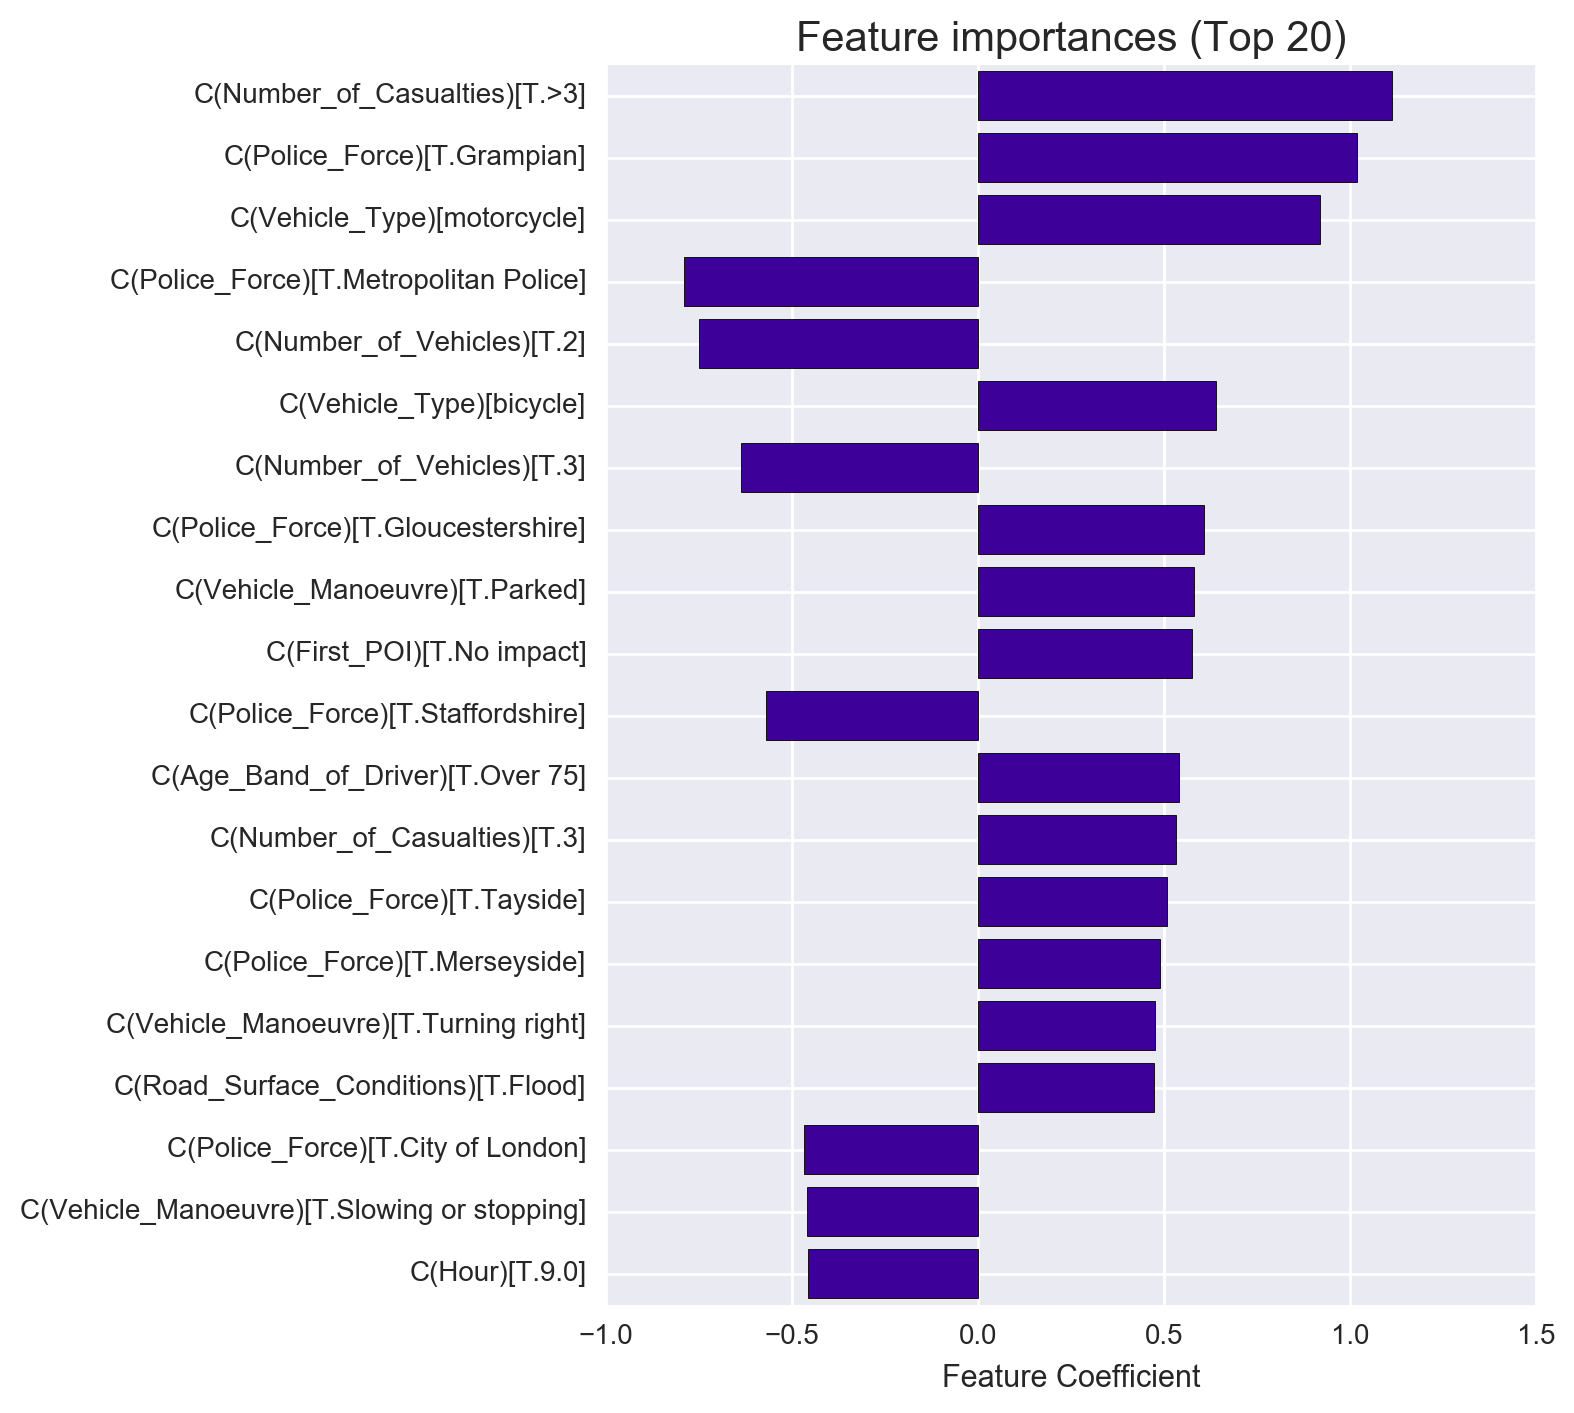

In [45]:
#Plotting feature importances:

plt.figure(figsize = (6, 8))
plt.title("Feature importances (Top 20)", fontsize = 15)
plt.barh(coeffs_gr.index[:20].sort_values(ascending=False), coeffs_gr.Coefficient[:20], align="center", color = '#3d0099')
plt.xlabel('Feature Coefficient')
plt.yticks(range(X.shape[1]), coeffs_gr.Feature[:20].sort_index(ascending=False))
plt.ylim([-0.5, 19.5])
plt.show()

Similarly as in default logistic regression, the most important features positively influencing severity of accidents are Number of Vehicles > 3 and Grampian Police Force, however Age Bracket > 75 became less important factor and Vehicle Type: Motorcycle became third most associated feature with severe accidents.

In [29]:
print "Classification report:"
print classification_report(y_test, y_hat_gr)

Classification report:
             precision    recall  f1-score   support

          0       0.66      0.66      0.66     11122
          1       0.66      0.66      0.66     11135

avg / total       0.66      0.66      0.66     22257



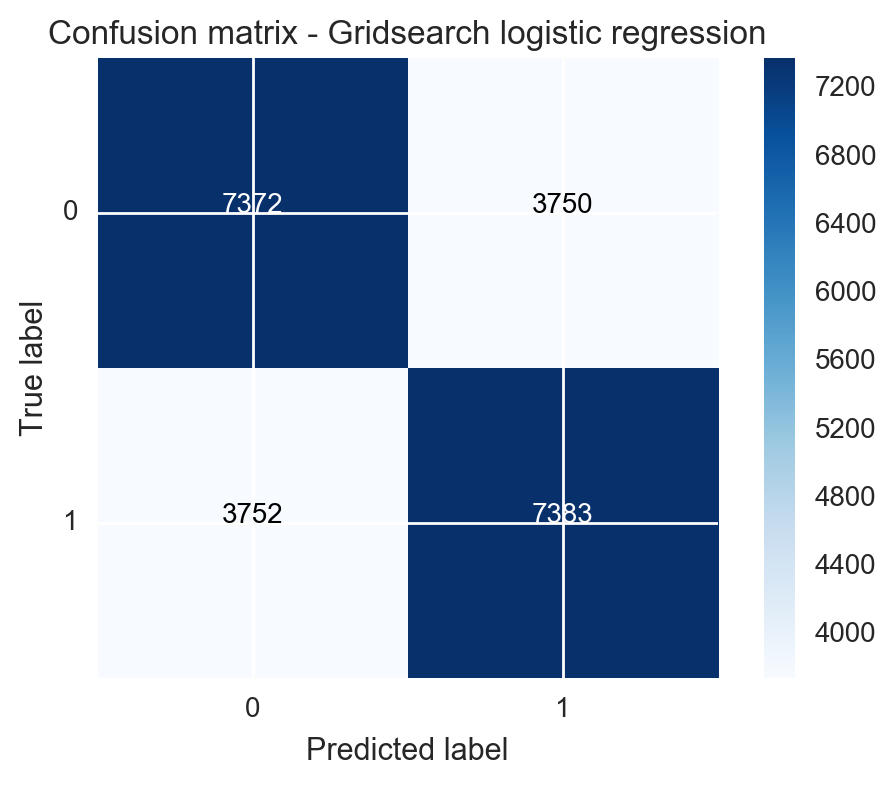

In [30]:
conf_matrix_gr = (confusion_matrix(y_test, y_hat_gr))
plot_confusion_matrix(conf_matrix_gr, [0,1], "Confusion matrix - Gridsearch logistic regression", cmap=plt.cm.Blues)

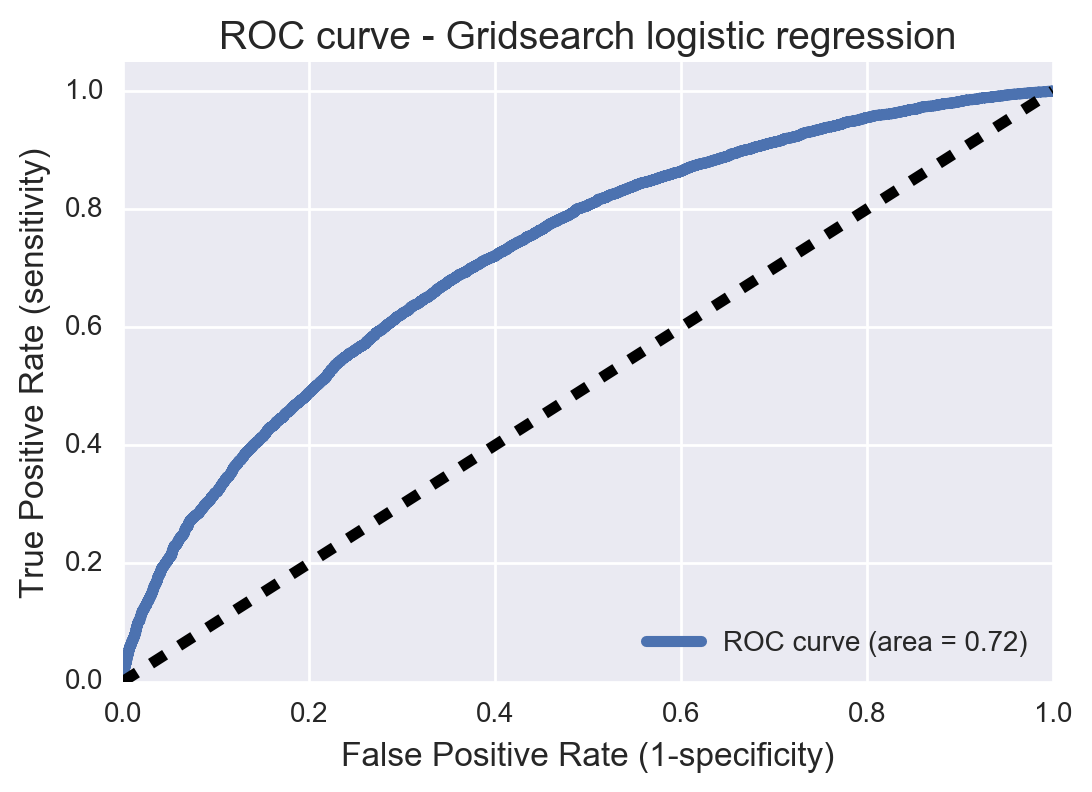

In [31]:
plot_ROC(gridsearch, "ROC curve - Gridsearch logistic regression")

The results of gridsearched logistic regression did not improve much on the defult logistic regression we have performed earlier and the results are nearly identical: accuracy score is 0.6629 versus 0.6619 from previous model. Area under the curve is still 0.72.

### 6. KNN
#### 6.1. K-5 Nearest Neighbours

In [32]:
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [33]:
#Accuracy score for test set
y_hat_knn = knn.predict(X_test)
score = accuracy_score(y_test, y_hat_knn)
print 'Accuracy score:', score

Accuracy score: 0.645774363122


In [34]:
#Cross-validated score
y_hat_CV_knn = cross_val_predict(knn, X_test, y_test, cv=5)
CV_score_knn = np.mean(cross_val_score(knn, X_test, y_test, cv=5))
print 'Cross-validated accuracy score:', CV_score_knn

Cross-validated accuracy score: 0.613424565343


In [35]:
print "Classification report:"
print classification_report(y_test, y_hat_CV_knn)

Classification report:
             precision    recall  f1-score   support

          0       0.61      0.63      0.62     11122
          1       0.62      0.60      0.61     11135

avg / total       0.61      0.61      0.61     22257



Both accuracy scores and also precision and recall for KNN model with 5 neighbours are worse than in logistic regression, which had an accuracy, precision and recall of approximately 0.66. 

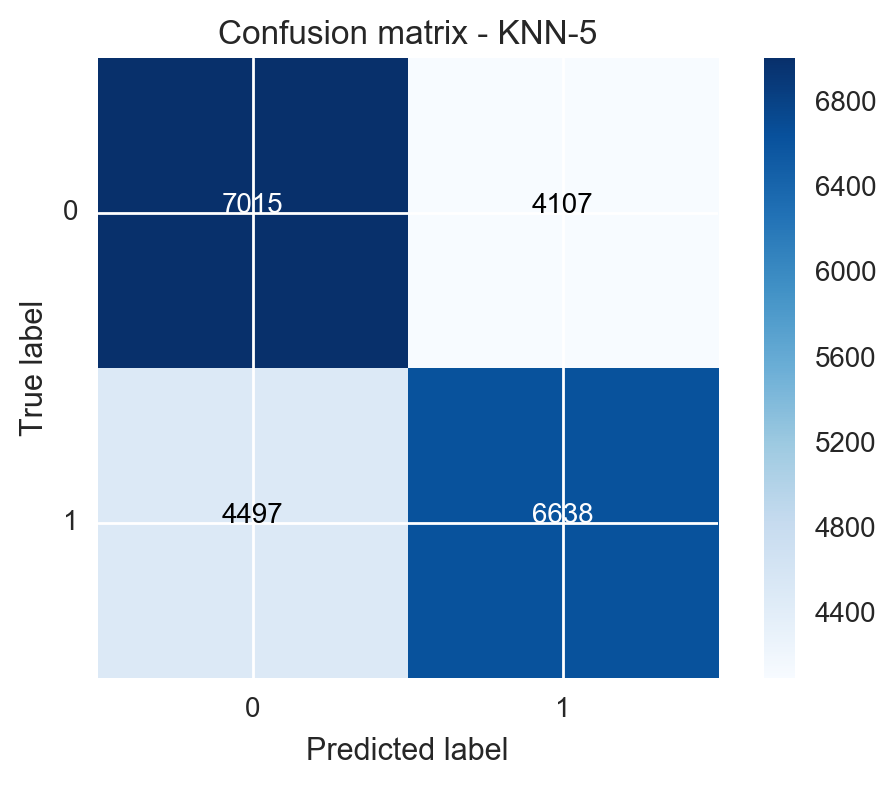

In [36]:
conf_matrix_knn5 = (confusion_matrix(y_test, y_hat_CV_knn))
plot_confusion_matrix(conf_matrix_knn5, [0,1], "Confusion matrix - KNN-5", cmap=plt.cm.Blues)

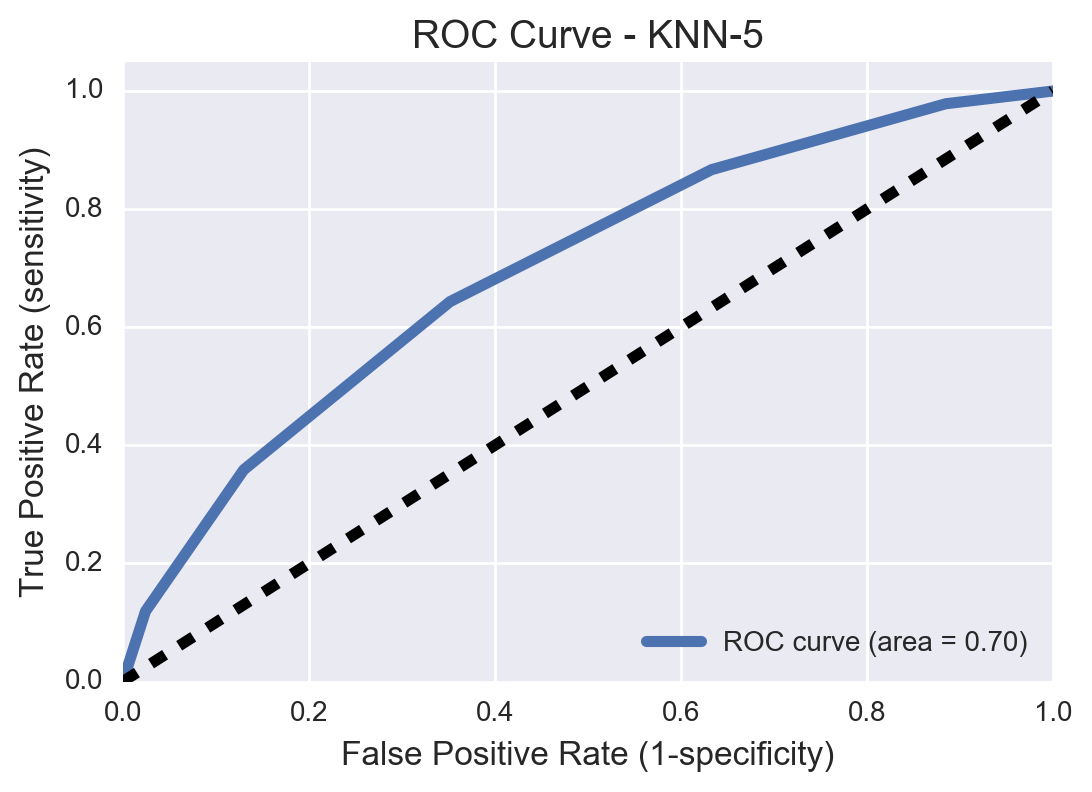

In [37]:
#Plotting ROC for KNN-5
probs = knn.predict_proba(X_test)
Y_score_knn5 = probs[:,1]

FPR, TPR, THR = roc_curve(y_test, Y_score_knn5)
ROC_AUC = auc(FPR, TPR)

plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-specificity)', fontsize=12)
plt.ylabel('True Positive Rate (sensitivity)', fontsize=12)
plt.title("ROC Curve - KNN-5", fontsize=14)
plt.legend(loc="lower right")
plt.show()

Both the confusion matrix and ROC curve confirm that the current model performs worse than Logistic Regression.

We will now use Gridsearch to see whether we can find parameters that would perform better.

#### 6.2. KNN with Gridsearch

In [47]:
knn_parameters = {'n_neighbors':range(1,10),'weights': ['uniform', 'distance']}
knngrid = GridSearchCV(KNeighborsClassifier(), param_grid = knn_parameters, verbose=True, cv=5, scoring='accuracy', n_jobs=4)
knngrid.fit(X_train, y_train)

print knngrid.best_score_
print knngrid.best_params_
print knngrid.best_estimator_


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 358.8min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed: 806.9min finished


0.661717982786
{'n_neighbors': 2, 'weights': 'distance'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='distance')


In [48]:
#Accuracy score
y_hat_gr_knn = knngrid.predict(X_test)
score = accuracy_score(y_test, y_hat_gr_knn)
print 'Accuracy score:', score

Accuracy score: 0.678348384778


The best parameters returned by gridsearch for kNN algorithm are k=2 and distance weights. With these parameters the accuracy score is 0.678 which is a slight improvement in comparison with Logistic Regression and quite significant improvement in comparison with kNN where k=5.

In [49]:
print "Classification report:"
print classification_report(y_test, y_hat_gr_knn)

Classification report:
             precision    recall  f1-score   support

          0       0.66      0.72      0.69     11122
          1       0.70      0.64      0.66     11135

avg / total       0.68      0.68      0.68     22257



Overall, precision and metrics have improved in comparison with previous model. However from the classification report it can be seen that the values for the classes differ quite significantly. Precision (TP / (TP + FP) ie the ability of the classifier not to label as positive a sample that is negative) is lower for class 0 than for class 1, and recall (TP/(TP+FN) ie the ability of the classifier to find all the positive samples) is opposite. 

Precision values tell us that our model has higher proportion of accidents diagnosed as severe (class 1) that actually have been severe, than proportion of accidents diagnosed as slight (class 0) that actually have been slight. 

On the other hand, recall values tell us that our model  has higher proportion of accidents that actually have been slight diagnosed as being slight, than proportion of accidents that actually have been severe diagnosed as being severe.

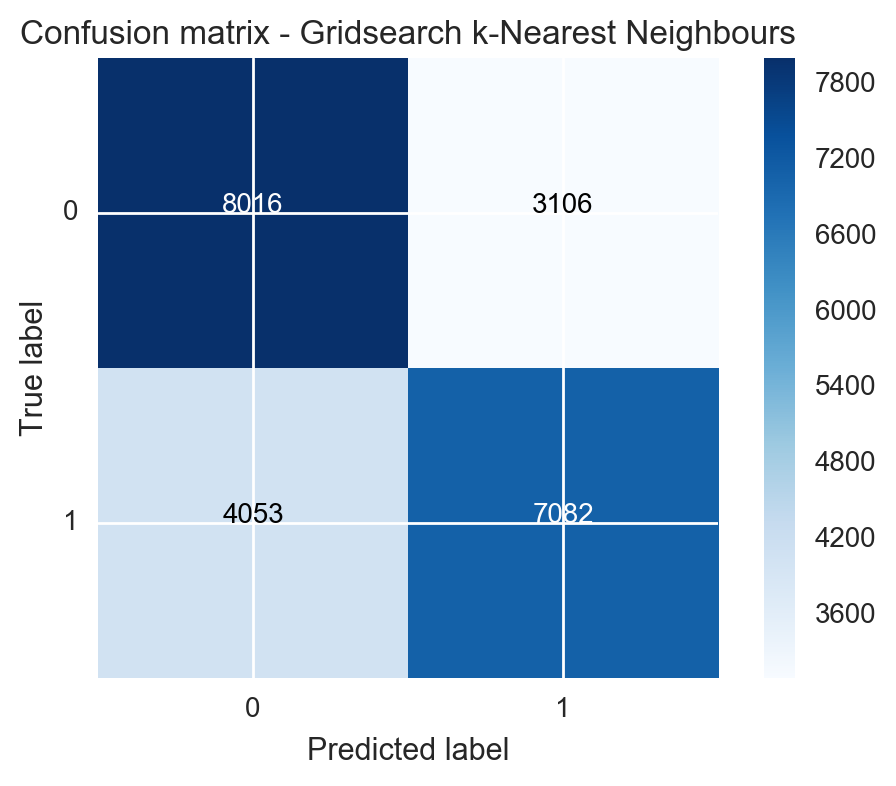

In [51]:
conf_matrix_gr_knn = (confusion_matrix(y_test, y_hat_gr_knn))
plot_confusion_matrix(conf_matrix_gr_knn, [0,1], "Confusion matrix - Gridsearch k-Nearest Neighbours", cmap=plt.cm.Blues)

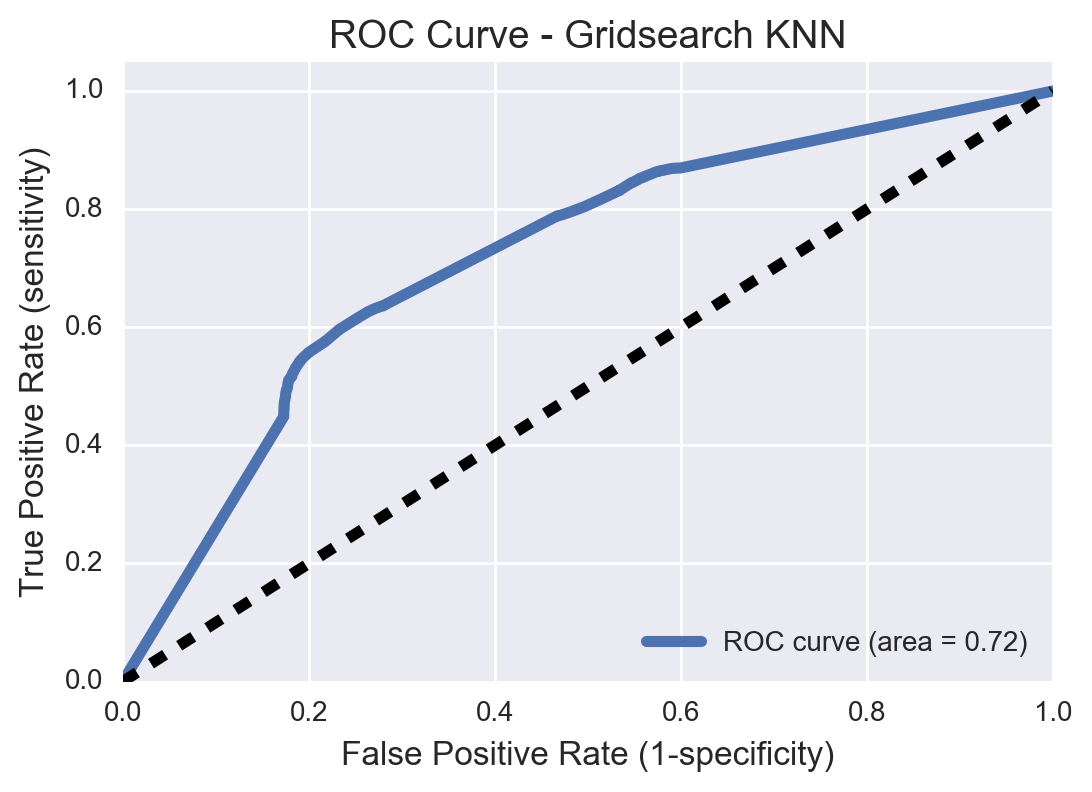

In [55]:
#Plotting ROC for KNN gridsearch
probs = knngrid.predict_proba(X_test)
Y_score_knn = probs[:,1]

FPR, TPR, THR = roc_curve(y_test, Y_score_knn)
ROC_AUC = auc(FPR, TPR)

plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-specificity)', fontsize=12)
plt.ylabel('True Positive Rate (sensitivity)', fontsize=12)
plt.title("ROC Curve - Gridsearch KNN", fontsize=14)
plt.legend(loc="lower right")
plt.show()

We can seee that although ROC curve changed shape slightly, area under the curve is still the same as in logistic regression, ie. 0.72.

For now Logistic Regression is still our best model, next we will implement Random Forest to see, if we can improve the accuracy.

### 7. Random Forest

#### 7.1. Random Forest (default)

In [38]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [39]:
y_hat_rf = rfc.predict(X_test)
rf_proba = rfc.predict_proba(X_test)
score = accuracy_score(y_test, y_hat_rf)
print 'Accuracy score:', score

Accuracy score: 0.644785910051


In [40]:
#Cross-validated score
y_hat_CV_rf = cross_val_predict(rfc, X_test, y_test, cv=5)
CV_score_rf = np.mean(cross_val_score(rfc, X_test, y_test, cv=5))
print 'Cross-validated accuracy score:', CV_score_rf
print 'Classification report'
print(classification_report(y_test,y_hat_CV_rf))

Cross-validated accuracy score: 0.623624207528
Classification report
             precision    recall  f1-score   support

          0       0.60      0.71      0.65     11122
          1       0.65      0.53      0.58     11135

avg / total       0.62      0.62      0.62     22257



In [44]:
#Coefficients
coeffs_rf = pd.DataFrame({'Coefficient': rfc.feature_importances_,'Feature':X.columns})
coeffs_rf["ABS_Coefficient"] = abs(coeffs_rf.Coefficient)
coeffs_rf.sort_values(by='ABS_Coefficient', ascending=False, inplace=True)
coeffs_rf.reset_index(inplace=True, drop=True)
coeffs_rf[:20]

,Coefficient,Feature,ABS_Coefficient
0,0.016592,C(Number_of_Vehicles)[T.2],0.016592
1,0.014820,C(Police_Force)[T.Metropolitan Police],0.014820
2,0.013996,C(Sex_of_Driver)[T.Male],0.013996
3,0.013921,C(First_Road_Class)[T.Unclassified],0.013921
4,0.013809,C(Vehicle_Type)[motorcycle],0.013809
5,0.013767,C(First_POI)[T.Front],0.013767
6,0.013609,C(Road_Surface_Conditions)[T.Wet],0.013609
7,0.013119,C(Age_Band_of_Driver)[T.26 - 35],0.013119
8,0.012470,C(Vehicle_Type)[car],0.012470
9,0.012407,C(Age_Band_of_Driver)[T.46 - 55],0.012407


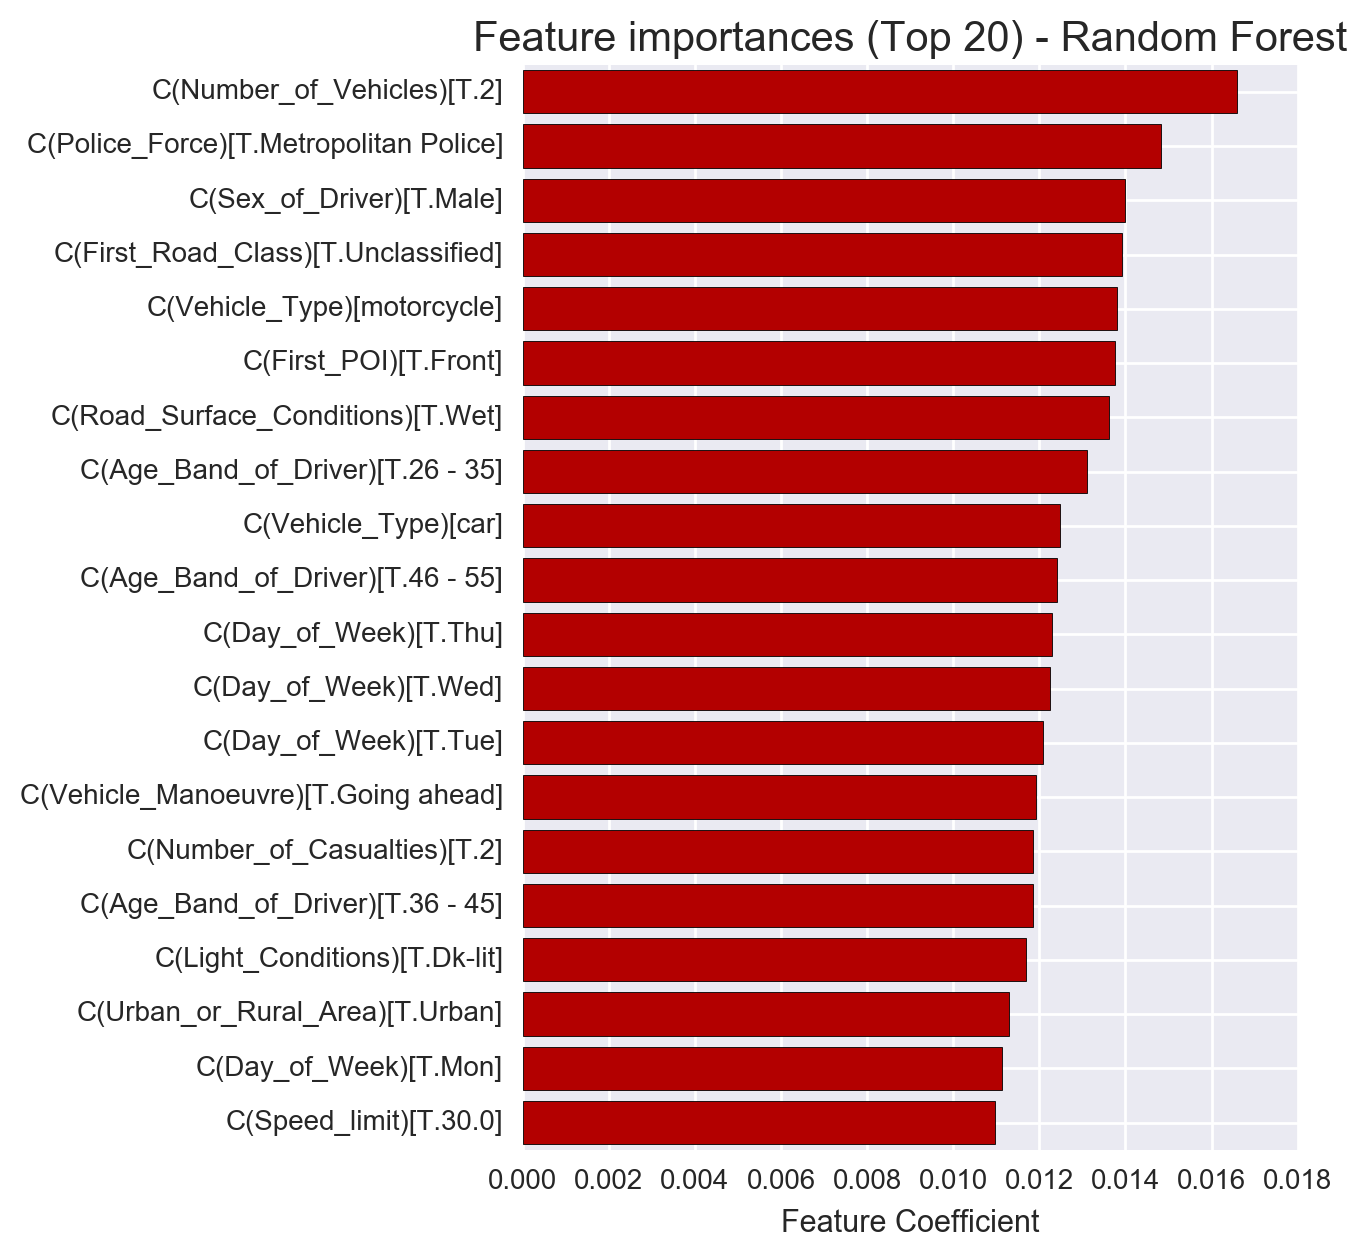

In [78]:
#Plotting feature importances:
plt.figure(figsize = (5, 7))
plt.title("Feature importances (Top 20) - Random Forest", fontsize = 15)
plt.barh(coeffs_rf.index[:20].sort_values(ascending=False), coeffs_rf.Coefficient[:20], align="center", color = '#b30000')
plt.xlabel('Feature Coefficient')
plt.yticks(range(X.shape[1]), coeffs_rf.Feature[:20].sort_index(ascending=False))
plt.ylim([-0.5, 19.5])
plt.show()

In [ ]:
#Description here

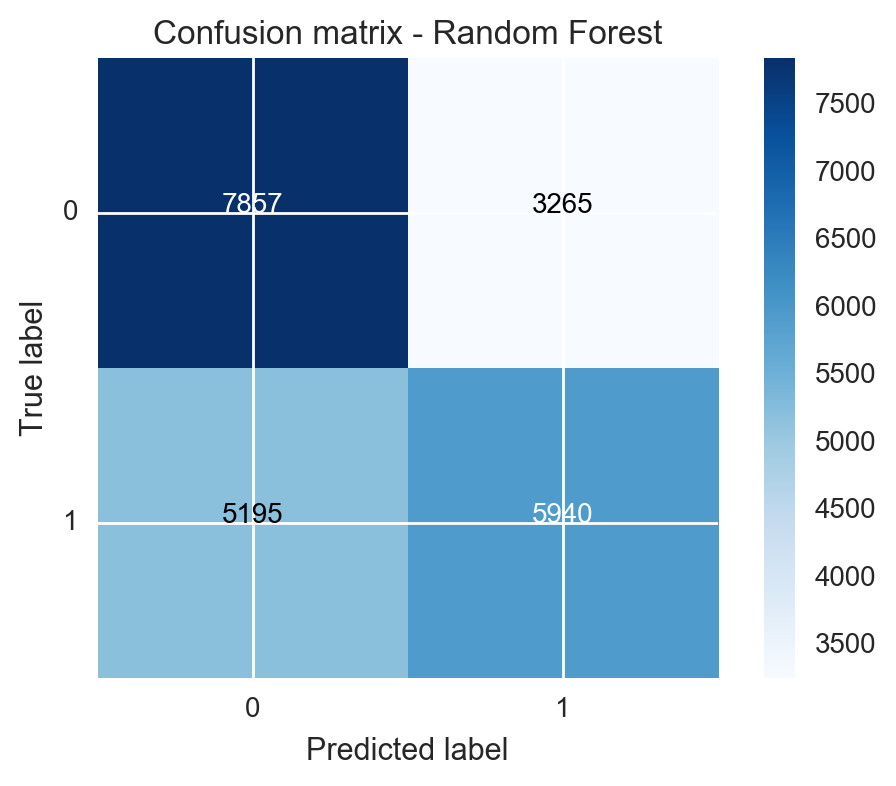

In [70]:
conf_matrix_cv_rf = (confusion_matrix(y_test, y_hat_CV_rf))
plot_confusion_matrix(conf_matrix_cv_rf, [0,1], "Confusion matrix - Random Forest", cmap=plt.cm.Blues)

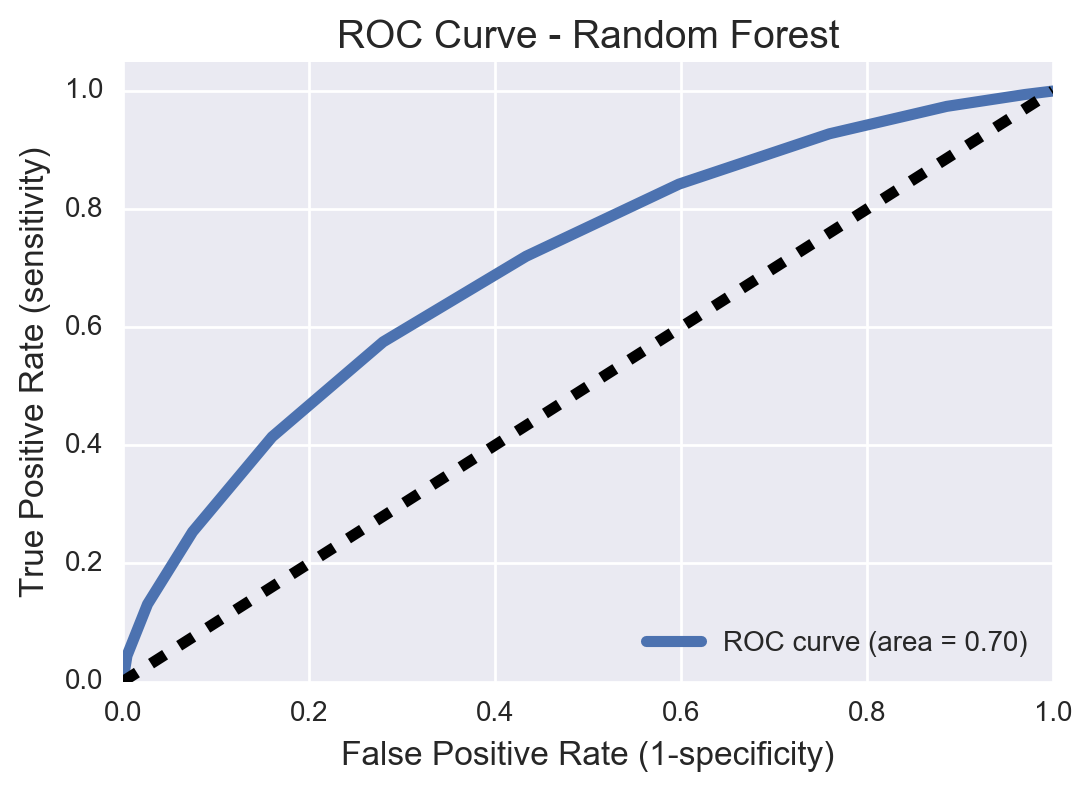

In [40]:
#Plotting ROC for RF
probs_rf = rf_proba
Y_score_rf = probs_rf[:,1]

FPR, TPR, THR = roc_curve(y_test, Y_score_rf)
ROC_AUC = auc(FPR, TPR)

plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-specificity)', fontsize=12)
plt.ylabel('True Positive Rate (sensitivity)', fontsize=12)
plt.title("ROC Curve - Random Forest", fontsize=14)
plt.legend(loc="lower right")
plt.show()

Default Random Forest returns worse metrics than previous models, perhaps with an one expection of recall for class 0. As we can see from the confusion matrix, the number of False Positives (instances of class 1 labelled as 0) considerably increased in comparison with previous models. Area under the curve has also decreased.

Let's now take a look at the learning curve of the model:

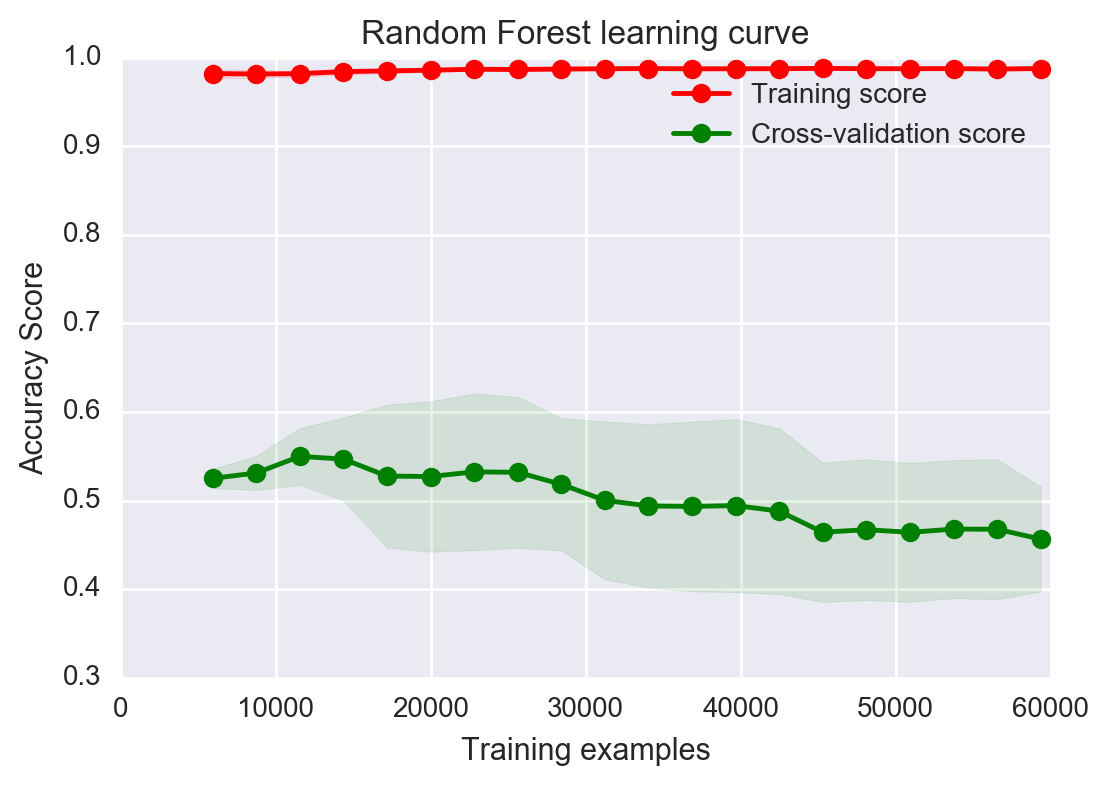

In [43]:
plot_learning_curve(rfc, title = "Random Forest learning curve", X=X, y=y, cv=5)
plt.show()

Similarly as in Logistic Regression, we can see that the values of cross-validated score decrease with the increasing volume of training examples, suggesting once again that there could be a large bias in our data.

We are now going to check whether we can find better parameters for out Random Forest model with the help of Gridsearch.

#### 7.2. Random Forest with Gridsearch 

In [55]:
rf_PARAMETERS = {"max_depth":[1,2,3,4,5,7,9,10,15,20,30,40,50], 
                 "n_estimators": [10,20,50,100,200,300,500,750,1000, 1250, 1500]}

grid_rf = GridSearchCV(rfc, param_grid=rf_PARAMETERS, scoring="accuracy", cv=5)
grid_rf.fit(X_train, y_train)

print grid_rf.best_estimator_
print grid_rf.best_score_
print grid_rf.best_params_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1500, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
0.682937631179
{'n_estimators': 1500, 'max_depth': 50}


In [56]:
y_hat_grid_ref = grid_rf.predict(X_test)
score = accuracy_score(y_test, y_hat_grid_ref)
print 'Accuracy score:', score

Accuracy score: 0.69065911848


In [57]:
print 'Classification report'
print(classification_report(y_test,y_hat_grid_ref))

Classification report
             precision    recall  f1-score   support

          0       0.69      0.69      0.69     11122
          1       0.69      0.70      0.69     11135

avg / total       0.69      0.69      0.69     22257



In [80]:
#Coefficients
coeffs_rf_gr = pd.DataFrame({'Coefficient': grid_rf.best_estimator_.feature_importances_,'Feature':X.columns})
coeffs_rf_gr["ABS_Coefficient"] = abs(coeffs_rf_gr.Coefficient)
coeffs_rf_gr.sort_values(by='ABS_Coefficient', ascending=False, inplace=True)
coeffs_rf_gr.reset_index(inplace=True, drop=True)
coeffs_rf_gr[:20]

,Coefficient,Feature,ABS_Coefficient
0,0.017601,C(Number_of_Vehicles)[T.2],0.017601
1,0.016055,C(Police_Force)[T.Metropolitan Police],0.016055
2,0.014177,C(Vehicle_Type)[car],0.014177
3,0.013872,C(First_POI)[T.Front],0.013872
4,0.013723,C(First_Road_Class)[T.Unclassified],0.013723
5,0.013601,C(Road_Surface_Conditions)[T.Wet],0.013601
6,0.013412,C(Sex_of_Driver)[T.Male],0.013412
7,0.012921,C(Age_Band_of_Driver)[T.26 - 35],0.012921
8,0.012276,C(Urban_or_Rural_Area)[T.Urban],0.012276
9,0.012083,C(Day_of_Week)[T.Wed],0.012083


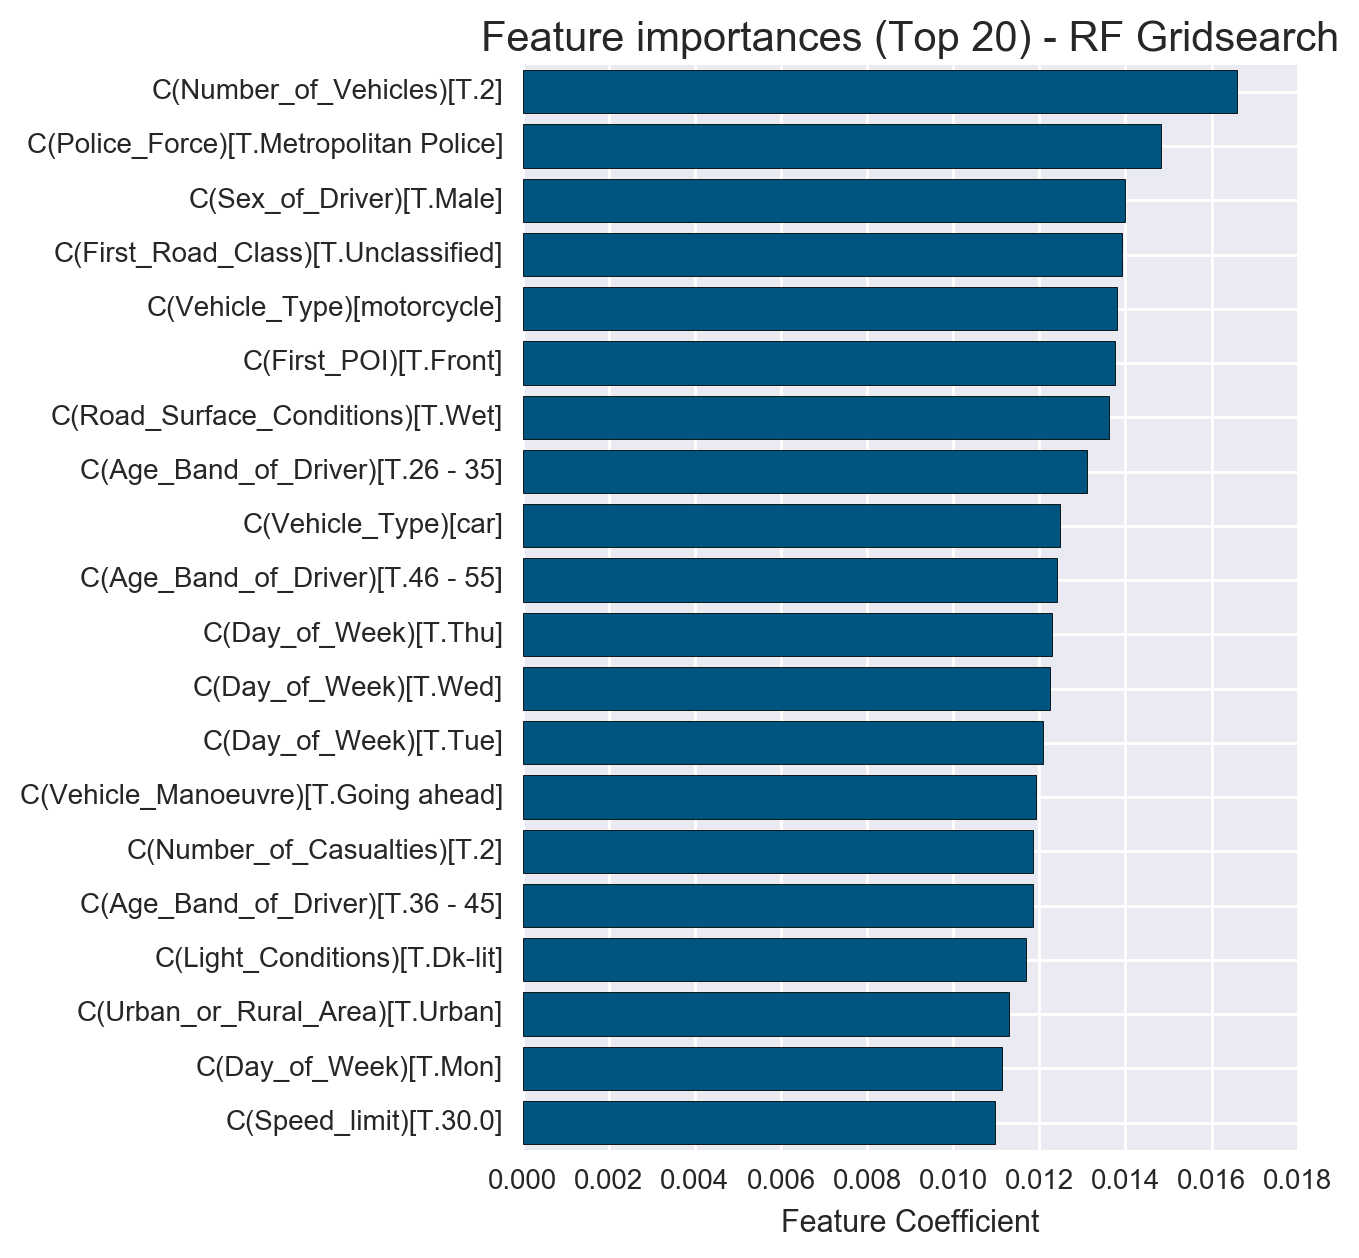

In [82]:
plt.figure(figsize = (5, 7))
plt.title("Feature importances (Top 20) - RF Gridsearch", fontsize = 15)
plt.barh(coeffs_rf.index[:20].sort_values(ascending=False), coeffs_rf.Coefficient[:20], align="center", color = '#005580')
plt.xlabel('Feature Coefficient')
plt.yticks(range(X.shape[1]), coeffs_rf.Feature[:20].sort_index(ascending=False))
plt.ylim([-0.5, 19.5])
plt.show()

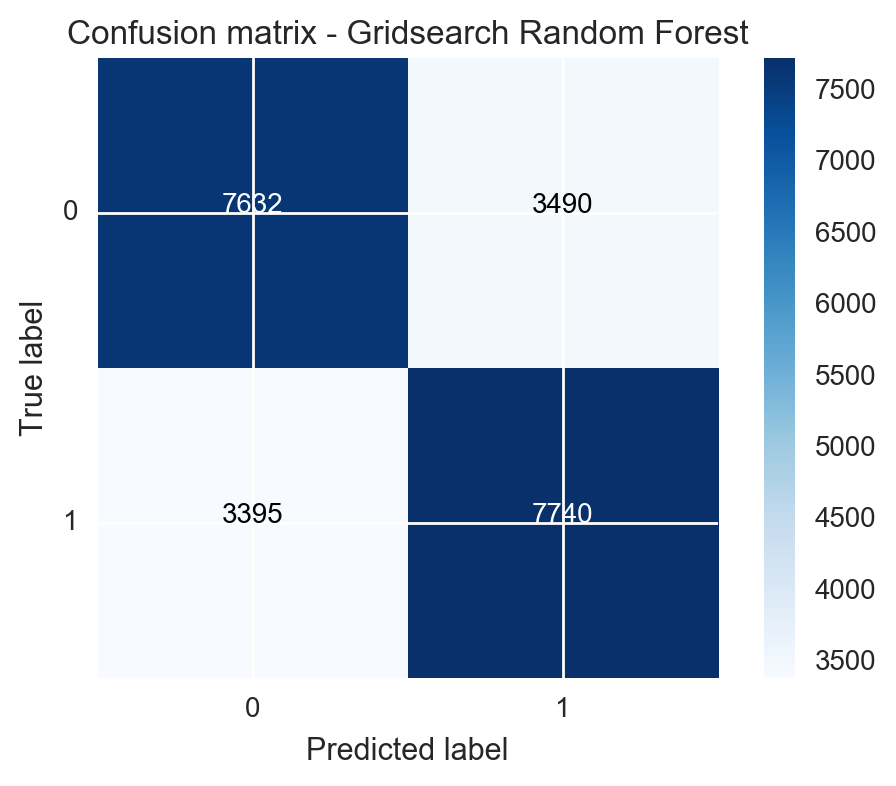

In [58]:
conf_matrix_grid_rf = (confusion_matrix(y_test, y_hat_grid_ref))
plot_confusion_matrix(conf_matrix_grid_rf, [0,1], "Confusion matrix - Gridsearch Random Forest", cmap=plt.cm.Blues)

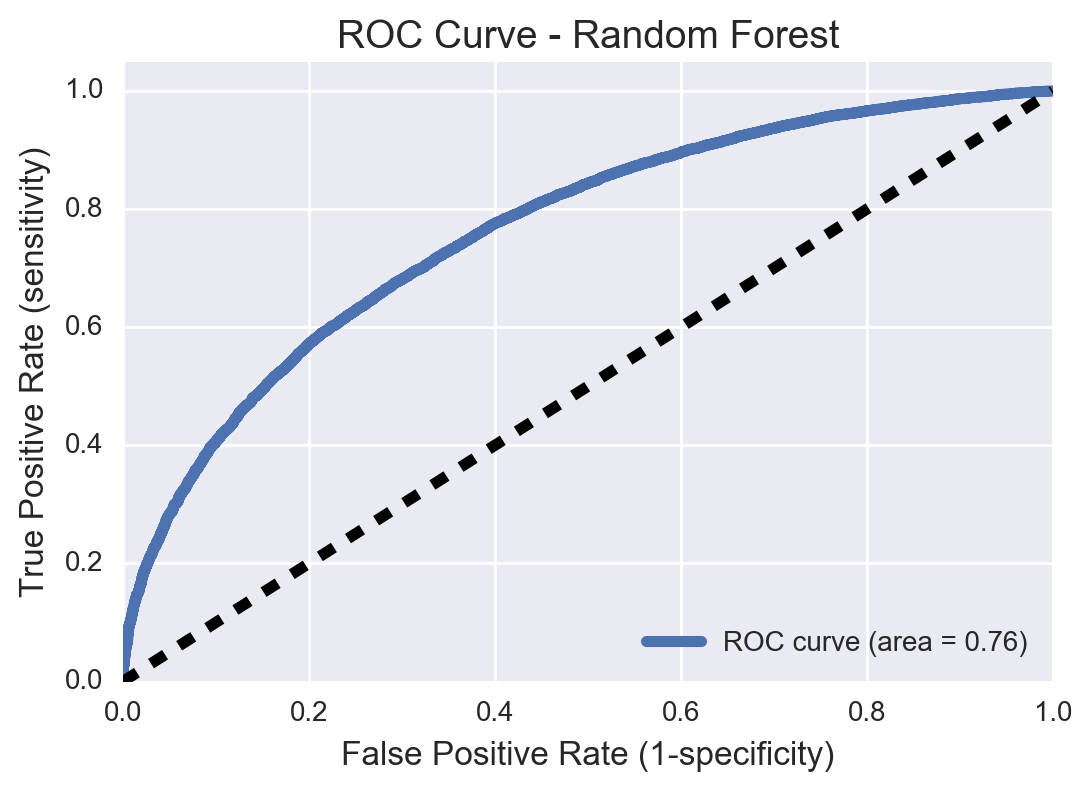

In [59]:
probs_rf = grid_rf.predict_proba(X_test)
Y_score_rf = probs_rf[:,1]

FPR, TPR, THR = roc_curve(y_test, Y_score_rf)
ROC_AUC = auc(FPR, TPR)

plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-specificity)', fontsize=12)
plt.ylabel('True Positive Rate (sensitivity)', fontsize=12)
plt.title("ROC Curve - Random Forest", fontsize=14)
plt.legend(loc="lower right")
plt.show()

Gridsearched Random Forest recommended 200 estimators and depth of 30 and the model with these parameters returns the best results so far. Accuracy score is 0.69, so are precision and recall and area under the curve is larger, returning the probabllity of 0.76 of model properly classifying severe accident.

For the last model in this part, we are going to use Support Vector Machines.

### 8. Support Vector Machines

In [72]:
sv_mach = svm.SVC(probability=True)
sv_mach.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [73]:
y_hat_svm = sv_mach.predict(X_test)
score = accuracy_score(y_test, y_hat_svm)

print 'Accuracy score:', score

Accuracy score: 0.665857932336


In [74]:
#Cross-validated score
y_hat_CV_svm = cross_val_predict(sv_mach, X_test, y_test, cv=5)
CV_score_svm = np.mean(cross_val_score(sv_mach, X_test, y_test, cv=5))
print 'Cross-validated accuracy score:', CV_score_svm
print 'Classification report'
print(classification_report(y_test,y_hat_CV_svm))

Cross-validated accuracy score: 0.660421636173
Classification report
             precision    recall  f1-score   support

          0       0.66      0.65      0.66     11122
          1       0.66      0.67      0.66     11135

avg / total       0.66      0.66      0.66     22257



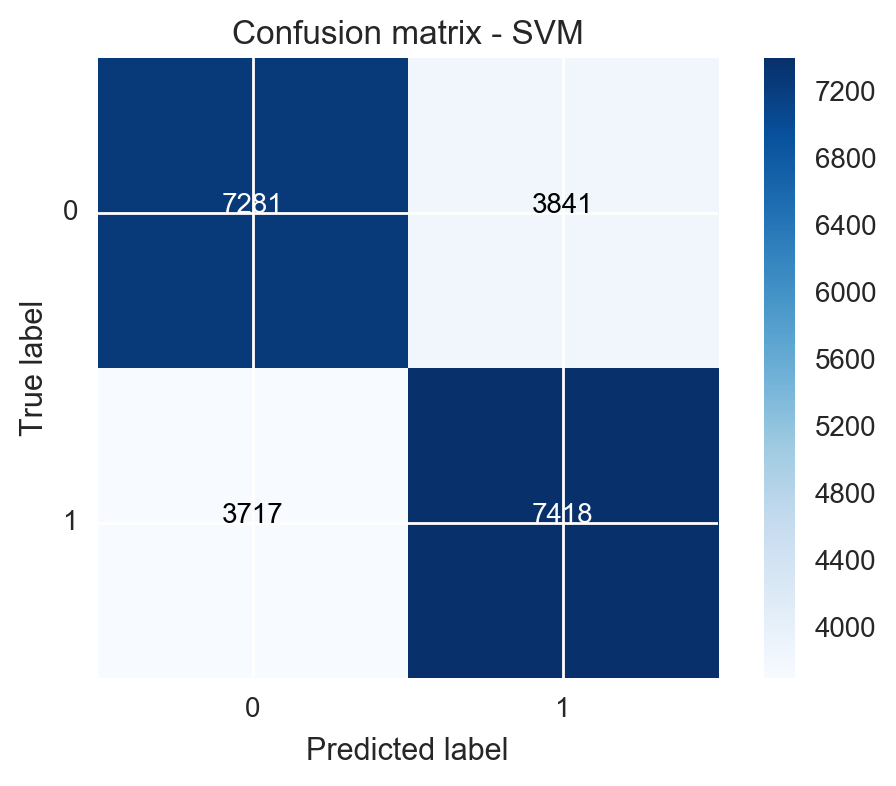

In [75]:
conf_matrix_svm = (confusion_matrix(y_test, y_hat_CV_svm))
plot_confusion_matrix(conf_matrix_svm, [0,1], "Confusion matrix - SVM", cmap=plt.cm.Blues)

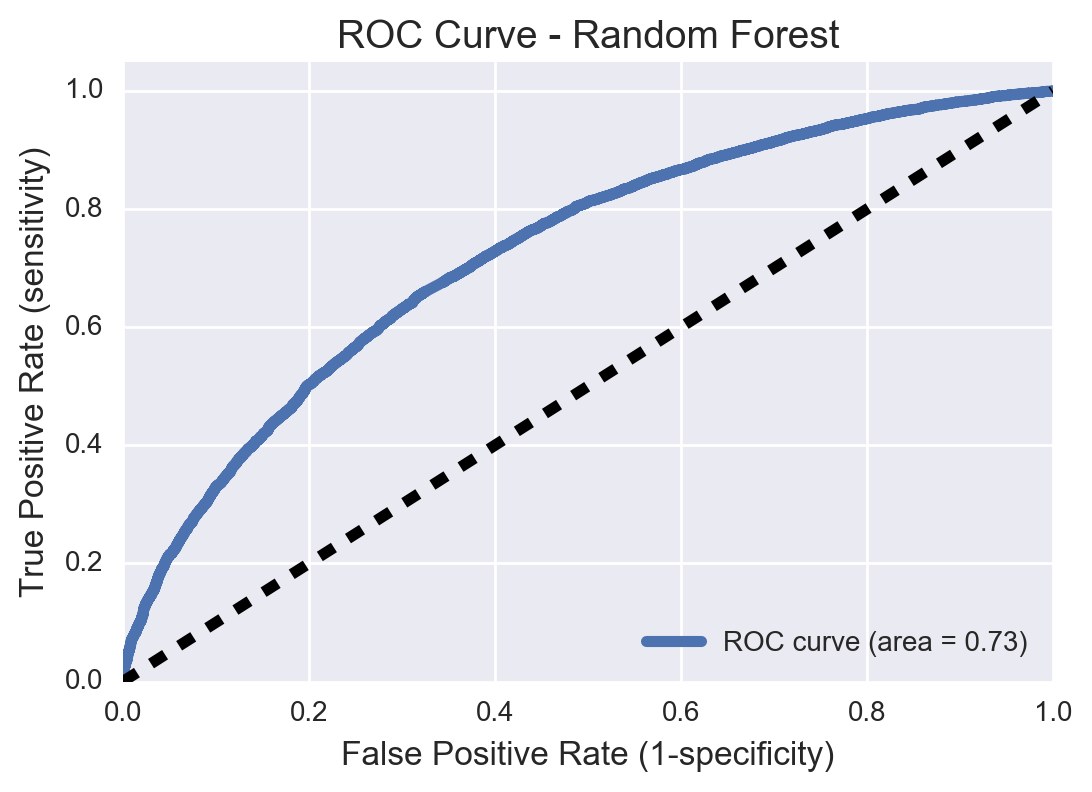

In [20]:
probs_sv = sv_mach.predict_proba(X_test)
Y_score_sv = probs_sv[:,1]

FPR, TPR, THR = roc_curve(y_test, Y_score_sv)
ROC_AUC = auc(FPR, TPR)

plt.plot(FPR, TPR, label='ROC curve (area = %0.2f)' % ROC_AUC, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1-specificity)', fontsize=12)
plt.ylabel('True Positive Rate (sensitivity)', fontsize=12)
plt.title("ROC Curve - Random Forest", fontsize=14)
plt.legend(loc="lower right")
plt.show()

SVM gives us moderately good results in comparison with other models, accuracy, precision and recall are all equal 0.66, similar to the results of Logistic Regression.

## C. Initial findings and progress summary

### Summary of findings

We have implemented and tested 4 types of classifiation models on our data: Logistic Regression, K-Nearest Neighbours, Random Forest and Support Vector Machines. Each of them, except the last one, has been implemented in two versions: a default one and optimized with the help of Gridsearch. 

All four model types performed better than a baseline model with accuracy of 0.5. 

The table below summarizes the evaluation metrics for each of the model and the chart displays the values of the accuracy score.

In [77]:
scores = pd.DataFrame(columns=('model', 'accuracy', 'precision', 'recall'))
scores.loc[scores.shape[0]] = ['Logit CV', 0.6619, 0.66, 0.66]
scores.loc[scores.shape[0]] = ['Logit Grid', 0.6630, 0.66, 0.66]
scores.loc[scores.shape[0]] = ['KNN-5 CV', 0.6134, 0.61, 0.61]
scores.loc[scores.shape[0]] = ['KNN Grid', 0.6783, 0.68, 0.68]
scores.loc[scores.shape[0]] = ['R Forest CV', 0.6236, 0.62, 0.62]
scores.loc[scores.shape[0]] = ['R Forest Grid', 0.6907, 0.69, 0.69]
scores.loc[scores.shape[0]] = ['SVM', 0.6604, 0.66, 0.66]
scores

,model,accuracy,precision,recall
0,Logit CV,0.6619,0.66,0.66
1,Logit Grid,0.6630,0.66,0.66
2,KNN-5 CV,0.6134,0.61,0.61
3,KNN Grid,0.6783,0.68,0.68
4,R Forest CV,0.6236,0.62,0.62
5,R Forest Grid,0.6907,0.69,0.69
6,SVM,0.6604,0.66,0.66


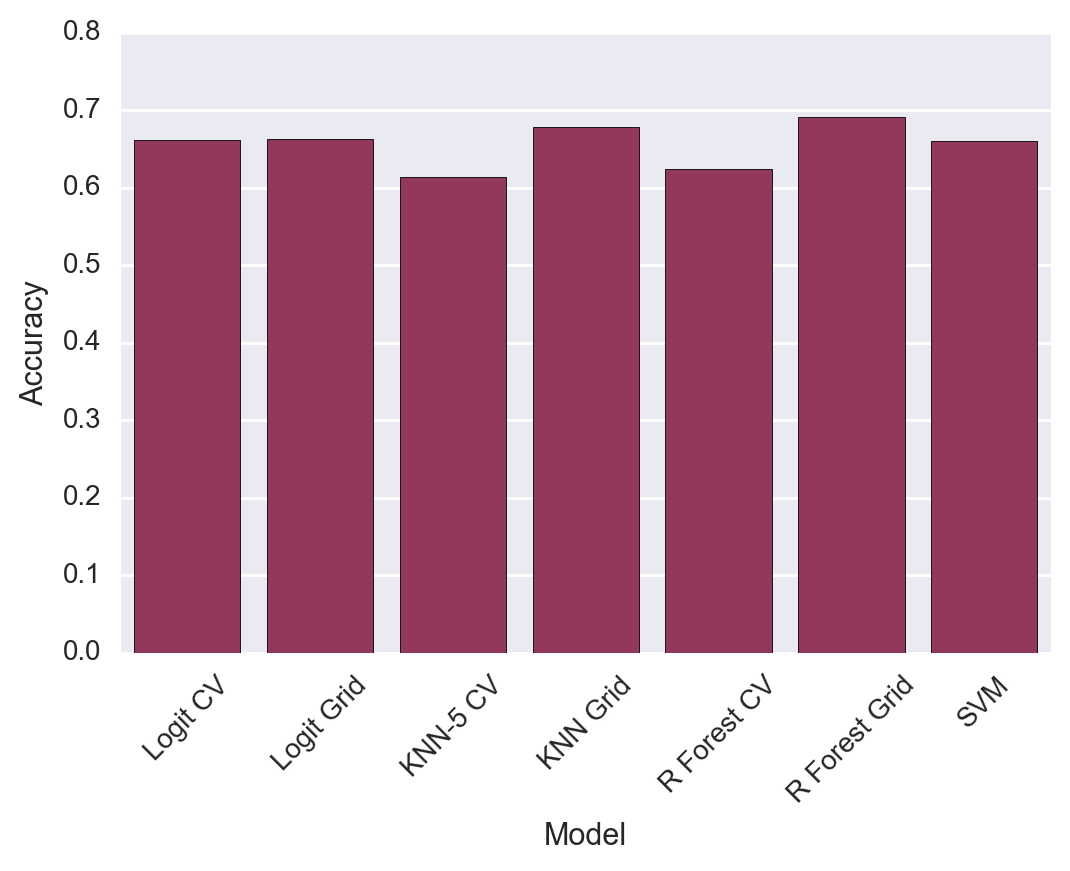

In [64]:
sns.barplot(x='model', y='accuracy', data=scores, order=None, ci=95, orient=None, 
            color='#a12957', palette=None, saturation=0.75)
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.ylim(0,.8)
plt.show()

The models with the lowest scores were KNN-5 and default Random Forest with accuracy of 0.61 and 0.63 respectively. This is interesting, considering that our best performing model was also Random Forest optimized by Gridsearch. Gridsearch recommended a very granular model with the number of estimators of 200 and depth of 30 and this model returned the accuracy of 0.69. Runner up was Gridsearched KNN with parameters k = 2 and distance weights, which returned the score of 0.68.

Overall the results are pretty similar and we can't say that any of the models is performing outstandingly well, however all of them perform better than the baseline and as such it can be said they have certain predicitive value. 

### Successes and setbacks

#### Successes

With the help of visualisations and exploratory data analysis we have detected certain underlying patterns in the data that could be associated with accident severity.

All models implemented have performed better than baseline model, proving that they carry a measure of predictive value and confirming our initial assumption that in our dataset indeed contains features that are associated with the accident severity and can serve as predictors.

In the case of Logistic Regression we managed to establish which features are the most associated with severe accidents.

We also managed to create model with highest accuracy score of 0.69 which was Random Forest with best parameters selected with the help of Gridsearch and area under the curve of 0.76 which means the probabllity of 0.76 of model properly classifying severe accident.

#### Setbacks

The largest setback was the processing time of the more complex models, especially when using Gridsearch. Even Logistic Regression with Gridsearch took nearly 7 minutes to compute, KNN took over 12 hours and unfortunately processing time for Gridsearch with SVM has been so long (over 31 hours and counting) that we had to abandon this way of finding the best parameters and go just with simpler default SVM model. 

The shape of learning curves for two of our models as seen above are suggesting that there is a lot of bias in our data and  that could be a reason why our models don't perform so well.

Another setback is the fact that we don't have any additional data that could improve our models. Perhaps data on breathalyzer tests of the drivers could be an important feature that influences accident's severity but unfortunately such data is not available for the year in question at the moment.

### What have we learned?

* dataset that appears like a good, clean dataset may not neccessarily be that clean. As we have seen, missing values are not always encoded as NaNs.
* the features that look like good predictors may not neccassarily be ones. The example is the speed limit which intuitively seems as an important factor when it comes to the severity of accidents. However when we plotted the feature importances the speed limit did not come up near the top.
* we are limited by the processing power of the computers

### Next steps

We could try to optimize the models further using dimensionality reduction techniques such as PCA. There is also and issue of bias in the data which perhaps could be remedied with futher feature engineering.

# PART 4 - REPORT & TECHNICAL ANALYSIS 

### Executive Summary

The goal of the project was to identify factors that influence the severity of casualties in road traffic accidents in the UK and create a classification model that, given a set of predictors, would determine said severity in future cases. 

The problem of identifying factors that influence the severity of the road traffic accidents has been researched and published before in many papers, for example [Impacts of accident severity factors and loss values of crashes on expressways in Thailand](http://www.sciencedirect.com/science/article/pii/S038611121300023X) where Multiple Logistic Regression has been used, or [Effects of Pavement Surface Conditions on Traffic Crash Severity](http://www.academia.edu/12588700/Effects_of_Pavement_Surface_Conditions_on_Traffic_Crash_Severity) where Ordered Logistic Regression has been used together with Random Forest for variable importance analysis.

This project has been based on two datasets concerning road traffic accidents which took place in 2015 in UK (excluding Northern Ireland), compiled by Department of Transport and downloaded from the [Data.gov.uk](https://data.gov.uk/dataset/road-accidents-safety-data) website. The statistics relate only to personal injury accidents on public roads that are reported to the police, and subsequently recorded, using the standard accident reporting form. The first dataset, Vehicles, listed all vehicles, that took part in accidents ending up in personal injury and contained columns related to accident circumstances and drivers demographics. Second dataset, Accidents, listed all accidents that ended up in personal injury and contained columns related to accident circumstances and location. 

We assumed that there is an association between certain features in the dataset and severity of accidents and that these features can serve as predictors in the modeling phase of the project. We also assumed that the data is as complete as possible and has been collected in fair and unbiased manner.

After conducting exploratory data analysis, creating visualisations and establishing the baseline model, 4 types of models have been tested and evaluated: Logistic Regression, k-Nearest Neighbours, Random Forest and Support Vector Machines. The models have been evaluated using accuracy scores, classification reports, confusion matrices and ROC curves.

All of the models performed better than baseline, the best one being Random Forest with 0.69 accuracy score. 

### Definition of variables

Data dictionary for vehicles table:
<img src="assets/data_dict1.png" style="width: 600px;">

Data dictionary for accidents table:
<img src="assets/data_dict2.png" style="width: 600px;">


The data dictionaries concernig the datasets subject of this project have been composed using information acquired from [Data.gov.uk](https://data.gov.uk/dataset/road-accidents-safety-data). The process of determining which column could be used in further analysis and modeling and serve as a variable consisted of the following steps:

1. Determinining which columns are not relevant to the process and dropping them; columns such as 'Driver_IMD_Decile',  'Location_Easting_OSGR', 'Location_Northing_OSGR'
2. Dropping columns that served their purpose in data analysis stage but will not be required in modelling phase, for example: 'Longitude' and 'Latitude'.
3. Dropping columns that contain too many NaNs or missing values that can't be imputed in a meaningful way, such as: 'Journey_Purpose_of_Driver', 'Age_of_Vehicle' or 'Propulsion_Code'.
4. Determining the suitability of features for modelling in EDA phase: detecting trends in variables and associations between them and the target.
5. Engineering new features based on the existing ones, for example: 'Hour of accident' or 'Month'.

The ultimate dataframe on which all the modelling has been performed, contained the following features:

In [68]:
bal_main.columns.tolist()

['Accident_Index',
 'Vehicle_Type',
 'Towing_and_Articulation',
 'Vehicle_Manoeuvre',
 'Vehicle_Loc',
 'Skidding_and_Overturning',
 'Vehicle_Leaving_Carriageway',
 'First_POI',
 'Left_Hand_Drive',
 'Sex_of_Driver',
 'Age_Band_of_Driver',
 'Police_Force',
 'Accident_Severity',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Day_of_Week',
 'First_Road_Class',
 'Road_Type',
 'Speed_limit',
 'Junction_Detail',
 'Junction_Control',
 'Scnd_Rd_Class',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area',
 'Hour',
 'Month',
 'Ped_Crossing']

### Identification of outliers

Most of the variables in the dataset are of categorical nominal type, therefore the anomalies or outliers have been hard to detect. In most features the classes were distributed in such way that outliers did not occur. 

There are however two numerical features in which we could determine the presence of outliers, namely the number of vehicles involved in an accident and number of casualties. As indicated on the charts, in both cases majority of observations fall in the 1-5 range and the values outside that range can be considered outliers, with maximum of 37 in case of vehicles and 38 in case of casualties. 

These outliers have been dealt with in the EDA phase by reassigning the classes and decreasing their number to make it easier to create dummies in the modelling phase.

<img src="assets/outliers.png">

### Model selection and implementation

The goal of this project is to classify the severity of accidents, therefore four different classification models have been implemented and tested.

The target for the models was the "Accident_Severity" column, which contained 3 different classes of accidents: Slight, Serious and Fatal. As, thankfully, the ratio of fatal accidents in the dataset is quite small, we had to deal with severe class imbalance problem in the target. To remedy this, two of the least numerous classes: Serious and Fatal have been merged, creating as a result binary category: Slight vs non-Slight, renamed as Slight vs Severe. Merging alone haven't however solved the imbalance problem entirely, as Slight class was still 5x more numerous than Severe class. We have therefore undersampled the majority class randomly picking the same number of observations from the class Slight, as we had in the class severe. This way balanced target for the models has been created.

The feature matrix was created with help of Patsy library, which turned all categorical features into dummy columns. Ultimately, the feature matrix contained 74190 observations and 186 features.

Before implementing models the set has been divided into train and test batches.

#### 1. Logistic Regression

First implemented model has been default Logistic Regression (without regularization). This model returned cross-validated accuracy score of 0.66 and Number_of_Casualties>3, Police_Force Grampian and Age_Band_of_Driver Over 75 as features most associated with Severe accidents category. Area under the curve for this model was 0.72.

For the next step, we have used Gridsearch to look for optimal parameters for the Logistic Regression and regularize the model. Gridsearch returned Lasso and C value of 1.78 as best parameters. The accuracy score has however improved  only very slightly and most important features look very similar to the default logit mode, with Number_of_Casualties >3 being the top one and Police_Force Grampian as the second most important. The third feature selected by Lasso has been Vehicle_Type - motorcycle. Area under the curve hasn't changed.

#### 2. KNN

Similarly to Logistic Regression, kNN has been implemented in two ways: 'default' one, using abitrary number of 5 neighbours, and gridsearched one.

The k-5 Nearest Neighbours perfmormed way worse than Logit, giving the cross-validated score of 0.61 and area under the curve of 0.70.

Next, with help of Gridsearch we have found the optimal parameters: k of 2 and distance weight. This combination of parameters improved the accuracy score substantially bringing it to 0.68. Area under the curve remained the same as in Logistic Regression, ie 0.72.

#### 3.Random Forest

Similarly as in previous model, implementation of Random Forest has been done in two steps: default and gridsearched. The default model did not perform well, with accuracy score of only 0.62. 

Next, we have used Gridsearch to look for optimal depth and number of estimators in the model. Initially, the max_depth parameter had a range of 1 to 30 and estimators 10 to 200. The Gridsearch however chose the max values in both parameters as the optimal ones therefore we kept expanding both ranges. Ultimately, we have searched in the following ranges of parameters:

<img src="assets/RF_params.png" style="width: 600px;">

Also this time Gridsearch returned max values from both ranges as the optimal ones. Due to computational power of the machine we couldn't expand the ranges any further, as already for the range pictured above the processing time was over 12 hours. In any event, the accuracy score increased only very slightly with the increased range of parameters. The ultimate combination chosen by Gridsearch has been as follows: n_estimators: 1500, max_depth: 50. With these parameters the model performed quite well, with accuracy score of 0.69 and area under the curve of 0.76.

#### 4. Support Vector Machines

With Support Vector Machines we attempted to implement a similiar strategy as in all previous models, ie using default and gridsearched parameters. Unfortunately, processing time was again against us and after 31 hours of calaculating Gridsearch parameters it has been decided to abandon the Gridsearch and go ahead with default version only.

Support Vector Machines model performed similarly to Logistic Regression, returning the accuracy score of 0.66. 

The chart below compares the accuracy scores for all models implemented.

<img src="assets/accuracy_chart.png" style="width: 450px;">


#### Visualizations & statistical analysis

In the Exploratory Data Analysis stage we used visualisations to detect whether there is an association between the features of the dataset and examine their relation with the chosen target. 

In the first place we examined the geographic distribution of the accidents. The numbers in the legend refer to the severity of accidents: 1-Fatal, 2-Serious and 3-Slight.

<img src="assets/map_severity.png" style="width: 1000px;">

While it's hard to distinguish details on the map of such large scale, certain trends can be spotted: there is much more accidents in urban areas than outside large cities, however the severity of accidents is worse in rural areas. Analysis of the data confirms the findings from the map, the ratio of serious and fatal accidents is bigger in the rural areas::

<img src="assets/urban_rural.png" style="width: 600px;">

We also looked at relationship between temporal features and accident severity, ie distribution of accidents in weekdays and months:

<img src="assets/week.png" style="width: 600px;">

In the chart above we can see that although the frequency of accidents is lower at weekends, the ratio of Serious and Fatal injuries is higher than on weekdays.

<img src="assets/month.png" style="width: 600px;">

In the monthly chart we can see that contrary to the intuition, the most accidents don't happen in the winter months with the largest light deficit (December, January) but in the summer(July) and autumn (September, October, November). The months with the least number of accidents are February (probably due to its shortness), March and April. However we also can see that some months that have relatively low total number of accidents, have higher ratio of fatal accidents, like August or December .

We also looked at demographic features of the drivers. The stacked barchart below shows distribuiton of drivers in the age brackets broken down by gender:

<img src="assets/drivers.png" style="width: 600px;">

We have also examined the relationship between the speed limits and accident severity and number of casualties. We can see that in general, the severity of accidents as well as the number of casualties increase with speed limit.

<img src="assets/speed_limit.png" style="width: 600px;">

### Interpretation of findings and the measure of success

#### Metrics

The table below shows 3 types of metrics for each of the models: accuracy, precision and recall.

<img src="assets/metrics.png" style="width: 300px;">

Accuracy tells us about the proportion of correct results that a model achieved, precision is the ability of the classifier not to label as positive a sample that is negative and recall is the ability of the classifier to find all the positive samples.

In our models all three metrics are the same for any particular model, due to the fact that our set is binary and we have the same number of observations in each of the target classes.

To look closer at the models' predictive abilities, we can compare the confusion matrices for the classifiers. Below are the confusion matrices for Gridsearched versions of Logistic Regression, KNN and Random Forest as well as SVM model.

<img src="assets/conf_mat.png" style="width: 500px;">

From the charts we can see that indeed Random Forest model has the largest number of correctly predicted classes.

#### Feature importance

Two of the model types let us extract the feature importantes, namely Logistic Regression and Random Forest.

##### Logistic Regression

The chart below compares the feature importances for both versions of Logistic Regression model used in the project. The features with positive values are associated with Severe accidents while those with negative values are associated with Slight accidents.

It can be seen that in both cases two most influential features associated with Severe accidents are: Number of Vehicles: 3 and Police Force: Grampian. Third feature is not the same, while in default Logistic Regression model it's Age Bracket >75, in Gridsearched (Lasso) model it's Vehicle Type: Motorcycle. 

The top features that are associated with Slight accidents in both models are Police Force: Metropolitan and Number of Vehicles: 2.

<img src="assets/LR_feat.png" style="width: 1000px;">


##### Random Forest

In Random Forest models feature importance has a different meaning than in Logistic Regression. In the Logistic Regression the importance is based on the scale of coefficients while in the Random Forest it is calculated as ratio between the number of samples routed to a decision node involving that feature in any of the trees of the ensemble over the total number of samples in the training set.

The chart below displays feature importances for default Random Forest model and Gridsearched one. As we can see, the feature improtances are identical for both, however the top features are similar to those that scored highest in the Logistic Regression models.

<img src="assets/RF_feats.png" style="width: 1000px;">

#### Success measure

All four types of models implemented performed better than the baseline model with accuracy of 0.5, therefore in this sense the project can be considered as successful. The best model had accuracy score of 0.69 which is an improvement on baseline of nearly 40%. Of course, we would wish for better accuracy score than our best 0.69 to be able to better predict the occurence of Slight and Severe accidents, however, considering the available data, the models performed quite well and our hypothesis, that based on the dataset we can in fact predict the accident severity, holds true.


### Stakeholder and peer recommendations


#### Stakeholder recommendations 

We would recommend the Random Forest model with the following parameters: n_estimators: 1500, max_depth: 50 to be implemented for predicting accident severity. The outcomes of this project suggest that further effort into gathering more data on the subject, implementing more complex models, and investing in servers with more computing power to process the models could be a good investment to achieve better accuracy in predicting accident severity. Such improved project could be used by emergency services for quicker response and resource management and by the road authorities as a tool to prevent accidents.

#### Peer recommendations

* The missing values in the datasets have been encoded not only with NaN values, but also with -1. Therefore when dealing with missing values it is important to remember that clearing only NaNs is not sufficient to receive a 'clean' dataset.
* The correlation matrix and heatmap for out data does not provide very optimistic results however it must be noted that the dataset contains only categorical, and mostly nominal data encoded with numbers, therefore the tools such as correlation matrix and heatmap do not reflect the associations between the features properly. 
* There is a severe class imbalance in the target, as there is nearly 6 times as many Slight accidents as there is Serious and Fatal accidents. Therefore the problem of imbalance needs to be dealt with before modelling phase; undersampling being one of the methods to remedy this issue.
* The processing time of the more complex models, especially when using Gridsearch is very long on a standard computer. Even Logistic Regression with Gridsearch took nearly 7 minutes to compute, KNN took over 12 hours and unfortunately processing time for Gridsearch with SVM has been so long (over 31 hours and counting) that we had to abandon this way of finding the best parameters and go just with simpler default SVM model. It would therefore require larger processing power to process more complex, but perhaps more accurate models.
* The shape of learning curves for two of our models as seen above are suggesting that there is a lot of bias in our data and that could be a reason why our models don't perform better. Introducing more engineered features could help with reducing the bias.

#### Next steps

* Data on breathalyzer tests will hopefully be released by Department of Transport later in the year, perhaps it would be then worth to try and incorporate them into existing models to check, whether their performance would improve with the new data.
* The models could be further optimized using dimensionality reduction techniques such as PCA.
* Boosting could be used to improve predictions and reduce bias.

### Model's performance over time

Once the model is deployed into production, it is important to continue testing to track model performance over time. Some models tend to degrade and especially non-linear models are sensitive to changes in the variables. The models in this project are trained on multiple variables that are not immune to changes: road surfaces could deteriorate, the weather patterns can change, the quality of safety features like airbags in cars could improve and as a result the perfomance of features in the model can change. Adding new features to the model can also cause issues, causing other, older features to become redundant. 

Therefore the model needs to be tested on a regular basis, to control potential changes in the model performance and make sure that it is updated in appropriate manner to give the best results.

One of the simplest ways of controlling model's performance is to regularly compare it to the baseline model. Another way is to measure prediction bias, ie distribution of predicted labels vs distribution  of observed labels. In well performing models, it is usually the case that both distributions are equal. But as features change these distributions can become uneven, sending a signal that the model is deteriorating. Models which degrade over time need to be adjusted or replaced.